# init

In [1]:
import numpy as np
import pandas as pd
# import polars as pl
import os, sys
# print(os.getcwd())
os.chdir('/gpfs/data/healthcare-allocate/CLIF-MIMIC/code')
# print(os.getcwd())

proj_root = "/gpfs/data/healthcare-allocate/CLIF-MIMIC"
if proj_root not in sys.path:
    sys.path.append(proj_root)

# from code.custom_utils import *

## load tables

In [2]:
def load_mimic_table(module: {"icu", "hosp"}, table, file_type: {"csv", "parquet", "pq"} = "csv"):
    if file_type in ["pq", "parquet"]:
        return pd.read_parquet(f'../mimic-iv-2.2/{module}/{table}.parquet')
    elif file_type == "csv":
        return pd.read_csv(f'../mimic-iv-2.2/{module}/{table}.csv.gz')

In [3]:
patients = load_mimic_table("hosp", "patients") # gives gender
admissions = load_mimic_table("hosp", "admissions") # gives race and ethnicity

In [4]:
d_items = load_mimic_table("icu", "d_items", "csv")
chartevents = load_mimic_table("icu", "chartevents", "parquet")

In [5]:
procedureevents = load_mimic_table("icu", "procedureevents", "csv")
datetimeevents = load_mimic_table("icu", "datetimeevents", "csv")

In [6]:
inputevents = load_mimic_table("icu", "inputevents", "csv")
outputevents = load_mimic_table("icu", "outputevents", "csv")

In [7]:
# def resave_mimic_table_to_parquet(table: pd.DataFrame):
    # if not yet in memory, load it:
    # if not table:

In [8]:
# labevents = load_mimic_table("hosp", "labevents", "csv")
# labevents.to_parquet("../mimic-iv-2.2/hosp/labevents.parquet")
d_labitems = load_mimic_table("hosp", "d_labitems", "csv")
labevents = load_mimic_table("hosp", "labevents", "parquet")

poe = load_mimic_table("hosp", "poe", "csv")
poe_detail = load_mimic_table("hosp", "poe_detail", "csv")

transfers = load_mimic_table("hosp", "transfers", "csv")
icustays = load_mimic_table("icu", "icustays", "csv")

## load mappings

In [9]:
def load_mapping_csv(csv_name: str):
    return pd.read_csv(f"../mapping/mimic-to-clif-mappings - {csv_name}.csv")

In [10]:
vitals_mapping = load_mapping_csv("vitals")
resp_mapping = load_mapping_csv("respiratory_support")
resp_device_mapping = load_mapping_csv("device_category")
resp_mode_mapping = load_mapping_csv("mode_category")

In [11]:
# covert to a dict for df col renaming later
def construct_mapper_dict(mapping_df: pd.DataFrame, key_col: str, value_col: str, none = False):
    mapper_dict = dict(zip(mapping_df[key_col], mapping_df[value_col]))
    # to enable a None -> None mapping
    if none:
        mapper_dict[None] = None
    return mapper_dict

# vitals table
vital_name_mapper_dict = construct_mapper_dict(vitals_mapping, "itemid", "label = vital_name")
vital_category_mapper_dict = construct_mapper_dict(vitals_mapping, "itemid", "vital_category")
vital_site_mapper_dict = construct_mapper_dict(vitals_mapping, "itemid", "meas_site_name")

# resp support table
resp_mapper_dict = construct_mapper_dict(resp_mapping, "itemid", "variable")
resp_device_mapper_dict = construct_mapper_dict(resp_device_mapping, "device_name", "device_category")
resp_mode_mapper_dict = construct_mapper_dict(resp_mode_mapping, "mode_name", "mode_category")


# utils

## `CacheInfo` class

In [12]:
class CacheInfo:
    """
    CacheInfo object used to represent the current status of `lru_cache`
    """
    def __init__(self, max_size):
        self.max_size = max_size
        self.misses = 0
        self.hits = 0
        self.cur_size = 0
        # NOTE: you may add to this if you want, but do not modify the lines above
        # create an attribute in the CacheInfo class to store the cache dict
        self.cache_dict = {}
    
    def __repr__(self):
        return f"CacheInfo(hits={self.hits}, misses={self.misses}, max_size={self.max_size}, cur_size={self.cur_size})"

# first layer: a decorator factory
def lru_cache(max_size = 128):
    '''
    This function is a decorator factory that returns a decorator with a user-specified
    maximum size of the cache 

    Input:
        - max_size: the maximum size of the cache
    
    Output: 
        - a decorator
    '''
    # second layer: the decorator
    def decorator(func):
        '''
        This function is a decorator that takes in an original function and
        return a new, decorated function.

        Input: an original function

        Output: a new function
        '''
        # initialize an instance of the CacheInfo class
        cache_info = CacheInfo(max_size = max_size)
        def key_generator(*args, **kwargs):
            '''
            This helper function creates a unique key given every different 
            combination of positional and key-word arguments

            Input: 
                - *args: any position arguments
                - **kwargs: any key word arguments

            Output: 
                - a tuple that stores all the arguments and their data type
            '''
            # generates a tuple that stores the data type of each position arg
            args_type = tuple(map(lambda x: type(x), args))
            # kwargs is a dict, so we use items() to turn it into a seq of
            # key-value tuples, and add the data type of the key word arg
            # to the tuple, then use frozenset() to make it immutable and 
            # thus hashable
            kwargs_and_type = frozenset(
                       map(lambda tup: (tup, type(tup[1])), 
                           kwargs.items()))
            return (args, args_type, kwargs_and_type)
        def new_func(*args, **kwargs):
            '''
            This is the new function that replaces the original function.

            Input:
                - *args, **kwargs: any position and key word arguments

            Output:
                - the result of the new function
            '''
            key = key_generator(*args, **kwargs)        
            # if the key is already in the cache dict, i.e. the same args have
            # been provided before, there should be "memory" in the cache
            # we got a hit
            if key in cache_info.cache_dict:
                cache_info.hits += 1 
                # temporarily store the cache result first before we remove the key
                cached_result = cache_info.cache_dict[key]
                # remove the key
                cache_info.cache_dict.pop(key)
                # insert the same key to the tail of the dict
                cache_info.cache_dict[key] = cached_result
                return cached_result
            # when we have a new arg combination that is not seen before 
            # -- we have a "miss":
            else:
                cache_info.misses += 1  
                # add the output of the function to the dict
                cache_info.cache_dict[key] = func(*args, **kwargs)  
                # update cache size (length of the dict) 
                cache_info.cur_size = len(cache_info.cache_dict) 
                # if the cache exceeds the maximum size, remove the least recently used item
                if len(cache_info.cache_dict) > max_size:
                    # first covert the dict to a list so we can track the order
                    cache_list = list(cache_info.cache_dict.items())
                    # remove the first element in the list, which is the least 
                    # recently used item
                    cache_list.pop(0)
                    # convert the list back to a dict and update
                    cache_info.cache_dict = dict(cache_list)
                    # update the cache size again, which should = max_size
                    cache_info.cur_size = len(cache_info.cache_dict)  
                return cache_info.cache_dict[key]
        # update the attribute of the now-decorated new func
        new_func.cache_info = cache_info
        return new_func     
    return decorator

In [13]:
# FIXME: delete "ALREDAY MAPPED" at some pt
EXCLUDED_LABELS_DEFAULT = ["NO MAPPING", "UNSURE", "MAPPED ELSEWHERE", "SPECIAL CASE", "ALREADY MAPPED"] 

# find all the relevant item ids for a table
def get_relevant_item_ids(
    mapping_df: pd.DataFrame, decision_col: str, excluded_labels: list = EXCLUDED_LABELS_DEFAULT):
    '''
    decision_col:
    '''
    return mapping_df.loc[
        ~mapping_df[decision_col].isin(excluded_labels),
        "itemid"
        ].unique()

def rename_and_reorder_cols(df, rename_mapper_dict: dict, new_col_order: list):
    return (
        df.rename(columns = rename_mapper_dict)
        .reindex(columns = new_col_order)
        )

def find_duplicates(df, cols: list[str] = ["hadm_id", "time", "itemid"]):
    '''
    Check whether there are duplicates -- more than one populated value -- for what is supposed to be 
    unique combination of columns. That is, for the same measured variable (e.g. vital_category) at
    the same time during the same encounter, there should be only one corresponding value.
    '''
    return df[df.duplicated(subset = cols, keep = False)]

def check_duplicates(df, additional_cols: list):
    '''
    Check whether there are duplicates -- more than one populated value -- for what is supposed to be 
    unique combination of columns. That is, for the same measured variable (e.g. vital_category) at
    the same time during the same encounter, there should be only one corresponding value.
    '''
    cols_to_check = ["encounter_id", "recorded_dttm"].extend(additional_cols)
    return df[df.duplicated(subset = cols_to_check, keep = False)]

In [14]:
# @lru_cache()
def item_id_to_feature_value(item_id: int, col: str = "label", df = d_items):
    '''
    Find the corresponding feature value of an item by id.
    i.e. find the label, or linksto, or item with id 226732.
    '''
    print(f"searching for the {col} of item {item_id}")
    return df.loc[df["itemid"] == item_id, col].values[0]

# @lru_cache()
def item_id_to_label(item_id: int) -> str:
    '''
    Helper function that returns the "label" string of an item given its item_id. 
    '''
    return item_id_to_feature_value(item_id)

def item_id_to_events_df(item_id: int, simplify: bool = False) -> pd.DataFrame:
    '''
    Return in a pandas df all the events associated with an item id.
    - simplify: whether to return the original df (False), or a simplified one 
    with some columns (particulary timestamps) renamed to support integration 
    between different events df.  
    '''
    # find whether it is chartevents, or procedure events, etc.
    linksto_table_name = item_id_to_feature_value(item_id, col = "linksto")
    # turn string into a dj object
    linksto_df: pd.DataFrame = globals()[linksto_table_name]
    events_df = linksto_df.loc[linksto_df["itemid"] == item_id, :]
    # if does not simplify, return the original column
    if not simplify:
        return events_df
    # else, if simplified:
    elif linksto_table_name == "procedureevents": # FIXME: trach is complex and need additional attention
        events_df_simplified = events_df.loc[
            :, ['subject_id', 'hadm_id', 'stay_id', 'endtime', 'itemid', 'value', 'valueuom']
        ].rename(columns = {"endtime": "time"})
        return events_df_simplified
    elif linksto_table_name == "chartevents":
        events_df_simplified = events_df.loc[
            :, ['subject_id', 'hadm_id', 'stay_id', 'charttime', 'itemid', 'value', 'valueuom']
        ].rename(columns = {"charttime": "time"})
        return events_df_simplified
        
    # FIXME: likely an issue if data struct of different events table are different 

def item_ids_list_to_events_df(item_ids: list):
    df_list = [item_id_to_events_df(item_id, simplify = True) for item_id in item_ids]
    df_merged = pd.concat(df_list) #.head().assign(
        ## linksto = lambda df: df["itemid"].apply(lambda item_id: item_id_to_feature_value(item_id, col = "linksto"))
    # )
    return df_merged 
    # FIXME: automatically add the label and linksto table source columns -- create cache?

## `ItemFinder` class

In [15]:
class ItemFinder():
    def __init__(self, kw = None, df = d_items, col: str = "label", 
                 case: bool = False):
        '''
        Look up an item by keyword from the `d_items` table of the `icu` module.
        - df = `d_items`
        - col = {"label", "abbr"}
        '''
        self.kw = kw 
        self.df = df
        self.col = "abbreviation" if col == "abbr" else col
        self.case = case

        # df of items that match the key words
        self.kw_items_df = df[
            df[self.col].str.contains(kw, case = case, na = False)
        ]
        # list of ids for items that match the key words
        self.kw_items_ids = self.kw_items_df["itemid"].values
        # a string list of non-duplicated events table names, e.g. ["chartevents", "procedureevents"]
        self.linksto_table_names = self.kw_items_df["linksto"].unique()
                                                                
        self.kw_chartevents = chartevents.loc[
            chartevents["itemid"].isin(self.kw_items_ids),
            :
        ]
        self.item_freq = self.generate_item_freq()

        self.candidate_table = self.make_candidate_table()

    def generate_item_freq(self):
        '''
        Iterative over each events table, find the items freq therein, and combine into one df.
        '''
        freq_df_ls = [] # a list of df's
        for table_name in self.linksto_table_names:
            # fetch the object by name, i.e. chartevents, procedureevents, etc.
            events_df = globals()[table_name]
            # a df of events associated with the key word items
            kw_events_df = events_df.loc[
                events_df["itemid"].isin(self.kw_items_ids),
                :
            ]
            # a df of item freq for one event type  
            item_freq_df = kw_events_df.value_counts("itemid")

            # check if the df is empty
            if not item_freq_df.empty:
                freq_df_ls.append(item_freq_df)
        
        # check if the list len is 0, meaning 
        if len(freq_df_ls) != 0:
            # return a df of all the item freq of all events table concat-ed together
            return pd.concat(freq_df_ls)
        else: 
            return self.kw_chartevents.value_counts("itemid")

    def make_candidate_table(self):
        '''
        # TODO
        '''
        if not self.item_freq.empty:
            return (
                self.kw_items_df
                .loc[:, ["itemid", "label", "abbreviation", "linksto", "category", "unitname", "param_type"]]
                # FIXME
                .join(self.item_freq, on = "itemid", validate = "1:1")
                .sort_values(by = "count", ascending = False) 
                .assign(
                    value_instances = lambda x: x["itemid"].apply(item_id_to_value_instances)
                )
            )
        else: 
            return "No matching result found."

@lru_cache()
def item_id_to_value_instances(item_id: int):
    '''
    Wrapper
    '''
    label = item_id_to_feature_value(item_id, "label")

    param_type = item_id_to_feature_value(item_id, "param_type")
    
    if param_type == "Numeric":
        val_instances = item_id_to_value_instances_numeric(item_id)
    elif param_type == "Text":
        val_instances = item_id_to_value_instances_categorical(item_id).to_dict()
    else:
        return param_type
    print(f"item label: {label}; value instances: {str(val_instances)}")
    return str(val_instances)

def item_id_to_value_instances_categorical(item_id: int, events: pd.DataFrame = chartevents):
    '''
    Return all the unique categories
    '''
    assoc_events = events.loc[events["itemid"] == item_id, :]
    categories: pd.Series = assoc_events.value_counts("value") 
    return categories
    
def item_id_to_value_instances_numeric(item_id: int, events: pd.DataFrame = chartevents):
    '''
    Find max, min, mean of a continuous, or numeric, item.
    '''
    valuenum_col = events.loc[events["itemid"] == item_id, :]["valuenum"]
    val_max, val_min, val_mean = valuenum_col.max(), valuenum_col.min(), round(valuenum_col.mean(), 2)
    return f"Max: {val_max}, Min: {val_min}, Mean: {val_mean}"

# `patient_encounters` table

In [ ]:
# Since each unique hospital visit for a patient is assigned a unique hadm_id, the admissions table can be considered as a definition table for hadm_id.


# `patient_demographics` table

## dev

In [36]:
# multiple race for one patient
race_counts = admissions.groupby('subject_id')['race'].nunique()
multi_race_indices = race_counts[race_counts > 1].index
multi_race_encounters = admissions[
    admissions['subject_id'].isin(multi_race_indices)
    ][["subject_id", "hadm_id", "race", "admittime", "admission_type", "admission_location"]]
multi_race_encounters

,subject_id,hadm_id,race,admittime,admission_type,admission_location
87,10002013,21763296,WHITE,2165-11-23 08:19:00,DIRECT EMER.,CLINIC REFERRAL
88,10002013,21975601,WHITE,2159-12-14 23:55:00,EW EMER.,EMERGENCY ROOM
89,10002013,23581541,OTHER,2160-05-18 07:45:00,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL
90,10002013,23745275,WHITE,2157-10-31 12:54:00,AMBULATORY OBSERVATION,PROCEDURE SITE
91,10002013,24760295,OTHER,2160-07-10 19:33:00,EW EMER.,EMERGENCY ROOM
...,...,...,...,...,...,...
431136,19997911,27144120,WHITE - OTHER EUROPEAN,2196-09-16 23:53:00,OBSERVATION ADMIT,EMERGENCY ROOM
431137,19997911,27402845,WHITE,2193-09-02 10:44:00,EU OBSERVATION,EMERGENCY ROOM
431190,19999287,20175828,BLACK/AFRICAN AMERICAN,2197-08-03 20:58:00,EW EMER.,EMERGENCY ROOM
431191,19999287,22997012,BLACK/AFRICAN AMERICAN,2197-07-26 03:29:00,EW EMER.,EMERGENCY ROOM


In [6]:
# but only one race per encounter: 
race_counts = admissions.groupby('hadm_id')['race'].nunique()
race_counts[race_counts > 1].index

Index([], dtype='int64', name='hadm_id')

In [9]:
# check for South Americans
south_american_subject_ids = admissions.loc[admissions["race"] == "SOUTH AMERICAN", "subject_id"].unique()
sa_race_counts = (
    admissions[admissions["subject_id"].isin(south_american_subject_ids)]
    .groupby('subject_id')['race'].nunique()
)
multi_race_indices = sa_race_counts[sa_race_counts > 1].index
multi_race_encounters = admissions[
    admissions['subject_id'].isin(multi_race_indices)
    ][["subject_id", "hadm_id", "race", "admittime", "admission_type", "admission_location"]]
multi_race_encounters

,subject_id,hadm_id,race,admittime,admission_type,admission_location
6419,10154376,24770530,SOUTH AMERICAN,2178-09-15 02:10:00,EU OBSERVATION,EMERGENCY ROOM
6420,10154376,26894987,UNKNOWN,2177-12-02 13:41:00,URGENT,PHYSICIAN REFERRAL
6421,10154376,27022201,HISPANIC OR LATINO,2174-07-28 18:23:00,EW EMER.,EMERGENCY ROOM
6422,10154376,27499017,HISPANIC OR LATINO,2174-08-09 22:34:00,EW EMER.,EMERGENCY ROOM
6423,10154376,27745331,UNKNOWN,2176-09-11 01:00:00,URGENT,PHYSICIAN REFERRAL
...,...,...,...,...,...,...
429330,19954807,21606941,SOUTH AMERICAN,2189-03-18 20:07:00,EW EMER.,PACU
429331,19954807,22024006,HISPANIC/LATINO - SALVADORAN,2193-09-22 20:19:00,OBSERVATION ADMIT,EMERGENCY ROOM
429332,19954807,23679253,HISPANIC/LATINO - SALVADORAN,2189-12-12 21:35:00,EU OBSERVATION,EMERGENCY ROOM
429333,19954807,27508241,HISPANIC/LATINO - SALVADORAN,2191-11-10 23:10:00,EU OBSERVATION,EMERGENCY ROOM


In [18]:
(sa_race_counts == 1).sum()

212

In [16]:
len(multi_race_encounters["subject_id"].unique())

56

# `limited_identifiers` table

## dev

In [ ]:
# adm and discharge time from `admissions` table



# `Encounter_demographics_disposition` table

In [35]:
admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


In [37]:
admissions.value_counts("discharge_location").reset_index()

,discharge_location,count
0,HOME,155423
1,HOME HEALTH CARE,75572
2,SKILLED NURSING FACILITY,43024
3,REHAB,10523
4,DIED,8511
5,CHRONIC/LONG TERM ACUTE CARE,7144
6,HOSPICE,3469
7,AGAINST ADVICE,2590
8,PSYCH FACILITY,2262
9,ACUTE HOSPITAL,1610


# `ADT` table

In [29]:
transfers.head(10)

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime
0,10000032,22595853.0,33258284,ED,Emergency Department,2180-05-06 19:17:00,2180-05-06 23:30:00
1,10000032,22595853.0,35223874,admit,Transplant,2180-05-06 23:30:00,2180-05-07 17:21:27
2,10000032,22595853.0,36904543,discharge,NaN,2180-05-07 17:21:27,NaN
3,10000032,22841357.0,34100253,discharge,NaN,2180-06-27 18:49:12,NaN
4,10000032,22841357.0,34703856,admit,Transplant,2180-06-26 21:31:00,2180-06-27 18:49:12
5,10000032,22841357.0,38112554,ED,Emergency Department,2180-06-26 15:54:00,2180-06-26 21:31:00
6,10000032,25742920.0,35509340,admit,Transplant,2180-08-06 01:44:00,2180-08-07 17:50:44
7,10000032,25742920.0,35968195,ED,Emergency Department,2180-08-05 20:58:00,2180-08-06 01:44:00
8,10000032,25742920.0,38883756,discharge,NaN,2180-08-07 17:50:44,NaN
9,10000032,29079034.0,32952584,ED,Emergency Department,2180-07-22 16:24:00,2180-07-23 05:54:00


In [25]:
transfers.value_counts("careunit").reset_index()

,careunit,count
0,Emergency Department,625907
1,Medicine,149709
2,Emergency Department Observation,80909
3,Discharge Lounge,52950
4,Med/Surg,47581
5,Medicine/Cardiology,44014
6,Neurology,39126
7,Hematology/Oncology,35542
8,Vascular,30939
9,Transplant,29963


In [46]:
dl = transfers[
    transfers["careunit"] == "Discharge Lounge"
]

In [50]:
dl_count = transfers.value_counts(["eventtype", "careunit"]).reset_index()
dl_count

,eventtype,careunit,count
0,ED,Emergency Department,625907
1,admit,Medicine,79483
2,admit,Emergency Department Observation,72522
3,transfer,Medicine,70226
4,admit,Discharge Lounge,39626
...,...,...,...
72,admit,Obstetrics Antepartum,700
73,admit,Neuro Stepdown,504
74,admit,Obstetrics Postpartum,104
75,admit,Unknown,72


In [26]:
transfers.value_counts("eventtype").reset_index()

,eventtype,count
0,ED,625907
1,admit,431241
2,discharge,431231
3,transfer,402593


In [31]:
adt_events_units = transfers.value_counts(["eventtype", "careunit"], dropna=False).reset_index()
adt_events_units

,eventtype,careunit,count
0,ED,Emergency Department,625907
1,discharge,NaN,431231
2,admit,Medicine,79483
3,admit,Emergency Department Observation,72522
4,transfer,Medicine,70226
...,...,...,...
73,admit,Obstetrics Antepartum,700
74,admit,Neuro Stepdown,504
75,admit,Obstetrics Postpartum,104
76,admit,Unknown,72


# `vitals` table

## utils

In [ ]:
vital_col_names = ["encounter_id", "recorded_dttm", "vital_name", "vital_category", "vital_value", "meas_site_name"]

vitals_temp_site_mapper_dict = {
    'Oral': 'not specified', 'Blood': 'not specified', 'Axillary': 'not specified', 
    'Rectal': 'core', 'Esophogeal': 'core', 'Temporal': 'not specified', 'Tympanic': 'core', 'NA': "not specified"}

vitals_col_rename_mapper_dict = {
    "hadm_id": "encounter_id", 
    "time": "recorded_dttm",
    "value": "vital_value"
    }

@lru_cache()
def convert_f_to_c(temp_f):
    if isinstance(temp_f, str) or isinstance(temp_f, int):
        temp_f = float(temp_f) 
    
    if isinstance(temp_f, float):
        temp_c = (temp_f - 32) * 5 / 9
        return round(temp_c, 1) # so 39.3333 -> 39.3
    else:
        raise("wrong type")

## regular cases

In [50]:
# find vital_items_ids
vitals_items_ids = get_relevant_item_ids(mapping_df = vitals_mapping, decision_col="meas_site_name")
vitals_events = item_ids_list_to_events_df(vitals_items_ids)
vitals_events

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom
0,10000032,29079034,39553978,2180-07-23 21:01:00,220179,82,mmHg
4,10000032,29079034,39553978,2180-07-23 22:00:00,220179,85,mmHg
10,10000032,29079034,39553978,2180-07-23 19:00:00,220179,93,mmHg
21,10000032,29079034,39553978,2180-07-23 20:00:00,220179,90,mmHg
163,10000032,29079034,39553978,2180-07-23 14:11:00,220179,84,mmHg
...,...,...,...,...,...,...,...
313446049,19995595,21784060,34670930,2126-10-22 04:00:00,225312,64,mmHg
313446200,19995595,21784060,34670930,2126-10-22 06:00:00,225312,97,mmHg
313452288,19995595,21784060,34670930,2126-10-21 21:00:00,225312,62,mmHg
313452316,19995595,21784060,34670930,2126-10-21 23:00:00,225312,71,mmHg


In [58]:
vitals_events["vital_name"] = vitals_events["itemid"].apply(lambda x: vital_name_mapper_dict[x])
vitals_events["vital_category"] = vitals_events["itemid"].apply(lambda x: vital_category_mapper_dict[x])
vitals_events["meas_site_name"] = vitals_events["itemid"].apply(lambda x: vital_site_mapper_dict[x])
# FIXME: efficiency

In [68]:
vitals_events

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom,vital_name,vital_category,meas_site_name
0,10000032,29079034,39553978,2180-07-23 21:01:00,220179,82,mmHg,Non Invasive Blood Pressure systolic,sbp,not specified
4,10000032,29079034,39553978,2180-07-23 22:00:00,220179,85,mmHg,Non Invasive Blood Pressure systolic,sbp,not specified
10,10000032,29079034,39553978,2180-07-23 19:00:00,220179,93,mmHg,Non Invasive Blood Pressure systolic,sbp,not specified
21,10000032,29079034,39553978,2180-07-23 20:00:00,220179,90,mmHg,Non Invasive Blood Pressure systolic,sbp,not specified
163,10000032,29079034,39553978,2180-07-23 14:11:00,220179,84,mmHg,Non Invasive Blood Pressure systolic,sbp,not specified
...,...,...,...,...,...,...,...,...,...,...
313446049,19995595,21784060,34670930,2126-10-22 04:00:00,225312,64,mmHg,ART BP Mean,map,arterial
313446200,19995595,21784060,34670930,2126-10-22 06:00:00,225312,97,mmHg,ART BP Mean,map,arterial
313452288,19995595,21784060,34670930,2126-10-21 21:00:00,225312,62,mmHg,ART BP Mean,map,arterial
313452316,19995595,21784060,34670930,2126-10-21 23:00:00,225312,71,mmHg,ART BP Mean,map,arterial


In [76]:
vitals_final = rename_and_reorder_cols(vitals_events, vitals_col_rename_mapper_dict, vital_col_names)
vitals_final

,encounter_id,recorded_dttm,vital_name,vital_category,vital_value,meas_site_name
0,29079034,2180-07-23 21:01:00,Non Invasive Blood Pressure systolic,sbp,82,not specified
4,29079034,2180-07-23 22:00:00,Non Invasive Blood Pressure systolic,sbp,85,not specified
10,29079034,2180-07-23 19:00:00,Non Invasive Blood Pressure systolic,sbp,93,not specified
21,29079034,2180-07-23 20:00:00,Non Invasive Blood Pressure systolic,sbp,90,not specified
163,29079034,2180-07-23 14:11:00,Non Invasive Blood Pressure systolic,sbp,84,not specified
...,...,...,...,...,...,...
313446049,21784060,2126-10-22 04:00:00,ART BP Mean,map,64,arterial
313446200,21784060,2126-10-22 06:00:00,ART BP Mean,map,97,arterial
313452288,21784060,2126-10-21 21:00:00,ART BP Mean,map,62,arterial
313452316,21784060,2126-10-21 23:00:00,ART BP Mean,map,71,arterial


### validation over duplicates

In [77]:
check_duplicates(vitals_final, ["vital_category", "vital_value"] )

,encounter_id,recorded_dttm,vital_name,vital_category,vital_value,meas_site_name


## `temp_c` special case

In [41]:
temp_events = item_ids_list_to_events_df([223761, 223762, 224642])
temp_events

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom
17,10000032,29079034,39553978,2180-07-23 20:00:00,223761,99.5,°F
162,10000032,29079034,39553978,2180-07-23 14:00:00,223761,98.7,°F
371,10000032,29079034,39553978,2180-07-23 17:00:00,223761,98.7,°F
550,10000980,26913865,39765666,2189-06-27 09:07:00,223761,98,°F
730,10000980,26913865,39765666,2189-06-27 12:00:00,223761,97.7,°F
...,...,...,...,...,...,...,...
313644553,19999987,23865745,36195440,2145-11-03 04:00:00,224642,Oral,None
313644735,19999987,23865745,36195440,2145-11-02 23:24:00,224642,Oral,None
313644811,19999987,23865745,36195440,2145-11-02 23:41:00,224642,Oral,None
313644876,19999987,23865745,36195440,2145-11-04 20:00:00,224642,Oral,None


In [12]:
# pivot directly
temp_wider = temp_events.pivot(
    index = ["hadm_id", "charttime"], 
    columns = "itemid",
    values = "value"
    ).reset_index()
temp_wider

itemid,hadm_id,charttime,223761,223762,224642
0,20000094,2150-03-02 15:30:00,97.5,NaN,Oral
1,20000094,2150-03-02 17:00:00,97.5,NaN,Oral
2,20000094,2150-03-02 20:00:00,96.3,NaN,Axillary
3,20000094,2150-03-03 04:00:00,99,NaN,Rectal
4,20000147,2121-08-30 22:11:00,97.6,NaN,Oral
...,...,...,...,...,...
1920380,29999828,2180-10-29 08:00:00,99.1,NaN,Oral
1920381,29999828,2180-10-29 09:00:00,98.2,NaN,Oral
1920382,29999828,2180-10-29 12:00:00,99.5,NaN,Oral
1920383,29999828,2180-10-29 14:00:00,99,NaN,Oral


In [16]:
# map temp_site to the clif categories of meas_site_name
temp_wider["meas_site_name"] = temp_wider[224642].apply(
    lambda x: vitals_temp_site_mapper_dict[x] if pd.notna(x) else "not specified"
)

# 223761 = temp in f, 223762 = temp in c
temp_wider["vital_value"] = temp_wider[223762].fillna(
    temp_wider[223761].apply(convert_f_to_c)
    )

temp_wider['vital_name'] = temp_wider.apply(
    lambda row: "Temperature Celsius" if pd.notna(row[223762]) else "Temperature Fahrenheit", 
    axis = "columns"
    )

temp_wider["vital_category"] = "temp_c"

In [64]:
temp_final = rename_and_reorder_cols(temp_wider, vitals_col_rename_mapper_dict, vital_col_names)
temp_final

itemid,encounter_id,recorded_dttm,vital_name,vital_category,vital_value,meas_site_name
0,20000094,2150-03-02 15:30:00,Temperature Fahrenheit,temp_c,36.4,not specified
1,20000094,2150-03-02 17:00:00,Temperature Fahrenheit,temp_c,36.4,not specified
2,20000094,2150-03-02 20:00:00,Temperature Fahrenheit,temp_c,35.7,not specified
3,20000094,2150-03-03 04:00:00,Temperature Fahrenheit,temp_c,37.2,core
4,20000147,2121-08-30 22:11:00,Temperature Fahrenheit,temp_c,36.4,not specified
...,...,...,...,...,...,...
1920380,29999828,2180-10-29 08:00:00,Temperature Fahrenheit,temp_c,37.3,not specified
1920381,29999828,2180-10-29 09:00:00,Temperature Fahrenheit,temp_c,36.8,not specified
1920382,29999828,2180-10-29 12:00:00,Temperature Fahrenheit,temp_c,37.5,not specified
1920383,29999828,2180-10-29 14:00:00,Temperature Fahrenheit,temp_c,37.2,not specified


In [39]:
temp_final = (
    temp_wider
    .rename(columns=vitals_col_rename_mapper_dict)
    .reindex(columns = vital_col_names)
)

temp_final

itemid,encounter_id,recorded_dttm,vital_name,vital_category,vital_value,meas_site_name
0,20000094,2150-03-02 15:30:00,Temperature Fahrenheit,temp_c,36.4,not specified
1,20000094,2150-03-02 17:00:00,Temperature Fahrenheit,temp_c,36.4,not specified
2,20000094,2150-03-02 20:00:00,Temperature Fahrenheit,temp_c,35.7,not specified
3,20000094,2150-03-03 04:00:00,Temperature Fahrenheit,temp_c,37.2,core
4,20000147,2121-08-30 22:11:00,Temperature Fahrenheit,temp_c,36.4,not specified
...,...,...,...,...,...,...
1920380,29999828,2180-10-29 08:00:00,Temperature Fahrenheit,temp_c,37.3,not specified
1920381,29999828,2180-10-29 09:00:00,Temperature Fahrenheit,temp_c,36.8,not specified
1920382,29999828,2180-10-29 12:00:00,Temperature Fahrenheit,temp_c,37.5,not specified
1920383,29999828,2180-10-29 14:00:00,Temperature Fahrenheit,temp_c,37.2,not specified


### validation over duplicates

In [72]:
check_duplicates(temp_final, ["vital_category",	"vital_value"] )

itemid,encounter_id,recorded_dttm,vital_name,vital_category,vital_value,meas_site_name


## merge and save

In [81]:
# COMBINE:
vitals_merged = pd.concat([
    vitals_final, temp_final
])
vitals_merged

,encounter_id,recorded_dttm,vital_name,vital_category,vital_value,meas_site_name
0,29079034,2180-07-23 21:01:00,Non Invasive Blood Pressure systolic,sbp,82,not specified
4,29079034,2180-07-23 22:00:00,Non Invasive Blood Pressure systolic,sbp,85,not specified
10,29079034,2180-07-23 19:00:00,Non Invasive Blood Pressure systolic,sbp,93,not specified
21,29079034,2180-07-23 20:00:00,Non Invasive Blood Pressure systolic,sbp,90,not specified
163,29079034,2180-07-23 14:11:00,Non Invasive Blood Pressure systolic,sbp,84,not specified
...,...,...,...,...,...,...
1920380,29999828,2180-10-29 08:00:00,Temperature Fahrenheit,temp_c,37.3,not specified
1920381,29999828,2180-10-29 09:00:00,Temperature Fahrenheit,temp_c,36.8,not specified
1920382,29999828,2180-10-29 12:00:00,Temperature Fahrenheit,temp_c,37.5,not specified
1920383,29999828,2180-10-29 14:00:00,Temperature Fahrenheit,temp_c,37.2,not specified


### validate the dtypes

In [82]:
vitals_merged.dtypes

encounter_id       int64
recorded_dttm     object
vital_name        object
vital_category    object
vital_value       object
meas_site_name    object
dtype: object

In [83]:
vitals_merged["vital_value"] = vitals_merged["vital_value"].apply(float)

In [85]:
vitals_merged

,encounter_id,recorded_dttm,vital_name,vital_category,vital_value,meas_site_name
0,29079034,2180-07-23 21:01:00,Non Invasive Blood Pressure systolic,sbp,82.0,not specified
4,29079034,2180-07-23 22:00:00,Non Invasive Blood Pressure systolic,sbp,85.0,not specified
10,29079034,2180-07-23 19:00:00,Non Invasive Blood Pressure systolic,sbp,93.0,not specified
21,29079034,2180-07-23 20:00:00,Non Invasive Blood Pressure systolic,sbp,90.0,not specified
163,29079034,2180-07-23 14:11:00,Non Invasive Blood Pressure systolic,sbp,84.0,not specified
...,...,...,...,...,...,...
1920380,29999828,2180-10-29 08:00:00,Temperature Fahrenheit,temp_c,37.3,not specified
1920381,29999828,2180-10-29 09:00:00,Temperature Fahrenheit,temp_c,36.8,not specified
1920382,29999828,2180-10-29 12:00:00,Temperature Fahrenheit,temp_c,37.5,not specified
1920383,29999828,2180-10-29 14:00:00,Temperature Fahrenheit,temp_c,37.2,not specified


In [84]:
# save
vitals_merged.to_parquet('../rclif/clif_vitals.parquet')

# `respiratory_support` table

## utils

In [97]:
resp_item_ids = get_relevant_item_ids(mapping_df = resp_mapping, decision_col = "variable")
resp_item_ids

array([220210, 220277, 226732, 223835, 220339, 224685, 224687, 224695,
       223834, 223848, 224690, 223849, 224688, 224684, 224738, 224686,
       224701, 224696, 229314, 224691, 224700, 225448, 226237, 227287,
       227577, 227579, 227580, 227582, 224702, 227581])

In [98]:
resp_events: pd.DataFrame = item_ids_list_to_events_df(resp_item_ids)
resp_events.head()

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom
7,10000032,29079034,39553978,2180-07-23 22:00:00,220210,20,insp/min
13,10000032,29079034,39553978,2180-07-23 19:00:00,220210,16,insp/min
24,10000032,29079034,39553978,2180-07-23 20:00:00,220210,19,insp/min
62,10000032,29079034,39553978,2180-07-23 21:00:00,220210,22,insp/min
167,10000032,29079034,39553978,2180-07-23 14:12:00,220210,24,insp/min


In [17]:
resp_events["variable"] = resp_events["itemid"].apply(lambda x: resp_mapper_dict[x])

In [18]:
resp_events

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom,variable
7,10000032,29079034,39553978,2180-07-23 22:00:00,220210,20,insp/min,resp_rate_obs
13,10000032,29079034,39553978,2180-07-23 19:00:00,220210,16,insp/min,resp_rate_obs
24,10000032,29079034,39553978,2180-07-23 20:00:00,220210,19,insp/min,resp_rate_obs
62,10000032,29079034,39553978,2180-07-23 21:00:00,220210,22,insp/min,resp_rate_obs
167,10000032,29079034,39553978,2180-07-23 14:12:00,220210,24,insp/min,resp_rate_obs
...,...,...,...,...,...,...,...,...
307312672,19809456,21636156,35472925,2176-12-18 22:24:00,227581,10,bpm,resp_rate_set
307312680,19809456,21636156,35472925,2176-12-19 04:00:00,227581,10,bpm,resp_rate_set
309766680,19878911,28565267,32426428,2118-12-07 20:00:00,227581,16,bpm,resp_rate_set
309766693,19878911,28565267,32426428,2118-12-08 00:00:00,227581,16,bpm,resp_rate_set


In [19]:
resp_columns = [
    "encounter_id", "recorded_dttm", "device_name", "device_category", 
    "mode_name", "mode_category", "tracheostomy", "fio2_set", "lpm_set",
    "tidal_volume_set", "resp_rate_set", "pressure_control_set", "pressure_support_set",
    "flow_rate_set", "peak_inspiratory_pressure_set", "inspiratory_time_set",
    "peep_set", "tidal_volume_obs", "resp_rate_obs", "plateau_pressure_obs",
    "peak_inspiratory_pressure_obs", "peep_obs", "minute_vent_obs"
    ]

In [20]:
resp_device_rank = ["Vent", "NIPPV", "CPAP", "High Flow NC", "Face Mask", "Trach Collar", "Nasal Cannula", "Room Air", "Other"]
resp_device_rank.index("Vent")

In [21]:
def map_one_stay(stay_id, table_events: pd.DataFrame):
    '''
    find all the relevant items within one stay, and match by charttime.
    
    - table_events: a df of all the events corresponding to that table.
    '''      
    stay_events: pd.DataFrame = table_events.loc[
        table_events["stay_id"] == stay_id, :
    ]
    
    #return stay_events
    # use helper func to check for duplicates
    duplicates = find_resp_duplicates(stay_events)
    # print(duplicates)
    # if there are duplicates, first remove them from the same `stay_events` df
    if not duplicates.empty:
        top_ranked_indices = duplicates.groupby(["hadm_id", "time", "itemid"])["rank"].idxmin()
        # non top-ranked categories to be dropped
        non_top_ranked_indices = duplicates.index.difference(top_ranked_indices)
        stay_events.drop(non_top_ranked_indices, inplace = True)
    
    stay_events = stay_events.assign(
        label = lambda df: df["itemid"].apply(item_id_to_label),
        variable = lambda df: df["itemid"].apply(lambda x: resp_mapper_dict[x])
    )

    return stay_events # return this for now, TODO: incorporate more after the code is tested

    wider = stay_events.pivot(
        index = ["hadm_id", "time"], 
        columns = ["itemid"],
        values = "value" # keep this just a str, not a list, to avoid having double col index
    ).reset_index()
    
    return wider # return this for now, TODO: incorporate more when the code is tested

## EDA

#### check duplicates

In [24]:
resp_duplicates.query("itemid == 224696") 

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom,variable
297727605,19529415,26871621,36123037,2166-07-20 01:00:00,224696,26,cmH2O,plateau_pressure_obs
297729572,19529415,26871621,39214730,2166-07-20 01:00:00,224696,37,cmH2O,plateau_pressure_obs


In [25]:
# 2166-07-19 23:50:00	2166-07-20 01:20:08
resp_events.query("stay_id == 39214730").sort_values("time")

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom,variable
297729518,19529415,26871621,39214730,2166-07-20 00:00:00,223848,Drager,None,device_name
297729520,19529415,26871621,39214730,2166-07-20 00:00:00,224700,8,cmH2O,peep_obs
297729523,19529415,26871621,39214730,2166-07-20 00:00:00,226732,Tracheostomy tube,None,device_name
297729519,19529415,26871621,39214730,2166-07-20 00:00:00,224696,35,cmH2O,plateau_pressure_obs
297729546,19529415,26871621,39214730,2166-07-20 00:17:00,224738,0.6,sec,inspiratory_time_set
297729542,19529415,26871621,39214730,2166-07-20 00:17:00,224690,28,insp/min,resp_rate_obs
297729544,19529415,26871621,39214730,2166-07-20 00:17:00,224695,45,cmH2O,peak_inspiratory_pressure_obs
297729537,19529415,26871621,39214730,2166-07-20 00:17:00,224684,400,mL,tidal_volume_set
297729539,19529415,26871621,39214730,2166-07-20 00:17:00,224687,14.8,L/min,minute_vent_obs
297729538,19529415,26871621,39214730,2166-07-20 00:17:00,224685,421,mL,tidal_volume_obs


In [26]:
# 2166-07-20 04:34:07 -> 2166-07-21 18:06:26
resp_events.query("stay_id == 36123037").sort_values("time").head(30)

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom,variable
297727600,19529415,26871621,36123037,2166-07-20 01:00:00,226732,Tracheostomy tube,None,device_name
297727606,19529415,26871621,36123037,2166-07-20 01:00:00,224700,12,cmH2O,peep_obs
297727605,19529415,26871621,36123037,2166-07-20 01:00:00,224696,26,cmH2O,plateau_pressure_obs
297727595,19529415,26871621,36123037,2166-07-20 01:00:00,223848,Drager,None,device_name
297727694,19529415,26871621,36123037,2166-07-20 01:21:00,220210,36,insp/min,resp_rate_obs
297727627,19529415,26871621,36123037,2166-07-20 01:21:00,223835,60,None,fio2_set
297727626,19529415,26871621,36123037,2166-07-20 01:21:00,220339,10,cmH2O,peep_set
297727632,19529415,26871621,36123037,2166-07-20 01:21:00,224685,366,mL,tidal_volume_obs
297727633,19529415,26871621,36123037,2166-07-20 01:21:00,224687,11,L/min,minute_vent_obs
297727637,19529415,26871621,36123037,2166-07-20 01:21:00,224695,31,cmH2O,peak_inspiratory_pressure_obs


In [27]:
icustays.query("hadm_id == 26871621") 

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
69624,19529415,26871621,36123037,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2166-07-20 04:34:07,2166-07-21 18:06:26,1.564109
69625,19529415,26871621,39214730,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2166-07-19 23:50:00,2166-07-20 01:20:08,0.062593


In [28]:
# find the time ranges for the two stays, and see which stay should the 1 am measurement fall into
# so should be stay_id == 39214730
transfers.query("hadm_id == 26871621").sort_values("intime")

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime
1801138,19529415,26871621.0,31849044,ED,Emergency Department,2166-07-19 21:05:00,2166-07-19 23:50:00
1801142,19529415,26871621.0,39214730,admit,Cardiac Vascular Intensive Care Unit (CVICU),2166-07-19 23:50:00,2166-07-20 01:20:08
1801141,19529415,26871621.0,38963722,transfer,Discharge Lounge,2166-07-20 01:20:08,2166-07-20 04:34:07
1801140,19529415,26871621.0,36123037,transfer,Cardiac Vascular Intensive Care Unit (CVICU),2166-07-20 04:34:07,2166-07-21 18:06:26
1801139,19529415,26871621.0,34433983,discharge,NaN,2166-07-21 18:06:26,NaN


## cleaning

In [111]:
# remove duplicates to prepare for pivoting 
# two kinds of duplicates to handle: by devices and other
resp_duplicates: pd.DataFrame = find_duplicates(resp_events)

In [112]:
# 1/ deal with devices
resp_duplicates_devices: pd.DataFrame = resp_duplicates.query("itemid == 226732").copy()
resp_duplicates_devices["device_category"] = resp_duplicates_devices["value"].apply(
    lambda x: resp_device_mapper_dict[x.strip()] if pd.notna(x) else None
    )
resp_duplicates_devices.dropna(subset="device_category",inplace=True)
resp_duplicates_devices["rank"] = resp_duplicates_devices["device_category"].apply(
    lambda x: resp_device_rank.index(x.strip()))
resp_duplicates_devices

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom,device_category,rank
8494,10001884,26184834,37510196,2131-01-19 18:40:00,226732,Aerosol-cool,None,Other,8
8495,10001884,26184834,37510196,2131-01-19 18:40:00,226732,Endotracheal tube,None,Vent,0
8496,10001884,26184834,37510196,2131-01-19 18:40:00,226732,Face tent,None,Face Mask,4
8504,10001884,26184834,37510196,2131-01-19 18:45:00,226732,Aerosol-cool,None,Other,8
8505,10001884,26184834,37510196,2131-01-19 18:45:00,226732,Endotracheal tube,None,Vent,0
...,...,...,...,...,...,...,...,...,...
313631762,19999442,26785317,32336619,2148-11-24 16:20:00,226732,Other,None,Other,8
313642973,19999987,23865745,36195440,2145-11-04 07:30:00,226732,Face tent,None,Face Mask,4
313642974,19999987,23865745,36195440,2145-11-04 07:30:00,226732,High flow neb,None,Other,8
313644011,19999987,23865745,36195440,2145-11-04 09:00:00,226732,Face tent,None,Face Mask,4


In [113]:
# deal with the device case - find indices to drop
top_ranked_device_indices = resp_duplicates_devices.groupby(["hadm_id", "time", "itemid"])["rank"].idxmin()
# non top-ranked categories to be dropped
lower_ranked_device_indices = resp_duplicates_devices.index.difference(top_ranked_device_indices)
# drop the designated indices
resp_events_clean = resp_events.drop(lower_ranked_device_indices)
# drop None
resp_events_clean.dropna(subset = "value", inplace=True)

In [116]:
# 2/ deal with duplicate vent reads:
setting_duplicate_indices_to_drop = find_duplicates(resp_events_clean).query("stay_id == 36123037").index
resp_events_clean.drop(setting_duplicate_indices_to_drop, inplace = True)

In [117]:
# check all duplicates are dropped
find_duplicates(resp_events_clean)

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom


In [ ]:
# create two columns based on item_id: 
resp_events_clean["label"] = resp_events_clean["itemid"].apply(item_id_to_label)
resp_events_clean["variable"] = resp_events_clean["itemid"].apply(lambda x: resp_mapper_dict[x])

In [132]:
resp_events_clean

,subject_id,hadm_id,stay_id,time,itemid,value,valueuom,label,variable
7,10000032,29079034,39553978,2180-07-23 22:00:00,220210,20,insp/min,Respiratory Rate,resp_rate_obs
13,10000032,29079034,39553978,2180-07-23 19:00:00,220210,16,insp/min,Respiratory Rate,resp_rate_obs
24,10000032,29079034,39553978,2180-07-23 20:00:00,220210,19,insp/min,Respiratory Rate,resp_rate_obs
62,10000032,29079034,39553978,2180-07-23 21:00:00,220210,22,insp/min,Respiratory Rate,resp_rate_obs
167,10000032,29079034,39553978,2180-07-23 14:12:00,220210,24,insp/min,Respiratory Rate,resp_rate_obs
...,...,...,...,...,...,...,...,...,...
307312672,19809456,21636156,35472925,2176-12-18 22:24:00,227581,10,bpm,BiPap bpm (S/T -Back up),resp_rate_set
307312680,19809456,21636156,35472925,2176-12-19 04:00:00,227581,10,bpm,BiPap bpm (S/T -Back up),resp_rate_set
309766680,19878911,28565267,32426428,2118-12-07 20:00:00,227581,16,bpm,BiPap bpm (S/T -Back up),resp_rate_set
309766693,19878911,28565267,32426428,2118-12-08 00:00:00,227581,16,bpm,BiPap bpm (S/T -Back up),resp_rate_set


## pivoting

In [143]:
resp_wider = resp_events_clean.pivot(
    index = ["hadm_id", "time"], 
    columns = ["variable", "label"],
    values = "value" 
)

In [147]:
resp_wider.columns.sort_index(level=0)

AttributeError: 'MultiIndex' object has no attribute 'sort_index'

In [137]:
resp_wider["lmp_set"] = resp_wider[223834].fillna(resp_wider[227287])

variable                        resp_rate_obs              ALREADY MAPPED  \
label                        Respiratory Rate O2 saturation pulseoxymetry   
hadm_id  time                                                               
20000094 2150-03-02 15:19:00               19                         NaN   
         2150-03-02 15:27:00              NaN                         100   
         2150-03-02 15:28:00               30                         NaN   
         2150-03-02 15:30:00               25                         NaN   
         2150-03-02 15:34:00              NaN                         NaN   
...                                       ...                         ...   
29999828 2180-10-29 12:00:00               19                          92   
         2180-10-29 13:00:00               16                          94   
         2180-10-29 14:00:00               17                          96   
         2180-10-29 15:09:00               14                          96   
         2180-10-29 16:00:00               14                          94   

variable                               device_name             fio2_set  \
label                        O2 Delivery Device(s) Inspired O2 Fraction   
hadm_id  time                                                             
20000094 2150-03-02 15:19:00                   NaN                  NaN   
         2150-03-02 15:27:00                   NaN                  NaN   
         2150-03-02 15:28:00                   NaN                  NaN   
         2150-03-02 15:30:00                   NaN                  NaN   
         2150-03-02 15:34:00         Nasal cannula                  NaN   
...                                            ...                  ...   
29999828 2180-10-29 12:00:00                   NaN                  NaN   
         2180-10-29 13:00:00                   NaN                  NaN   
         2180-10-29 14:00:00                   NaN                  NaN   
         2180-10-29 15:09:00                   NaN                  NaN   
         2180-10-29 16:00:00                   NaN                  NaN   

variable                     peep_set        tidal_volume_obs minute_vent_obs  \
label                        PEEP set Tidal Volume (observed)   Minute Volume   
hadm_id  time                                                                   
20000094 2150-03-02 15:19:00      NaN                     NaN             NaN   
         2150-03-02 15:27:00      NaN                     NaN             NaN   
         2150-03-02 15:28:00      NaN                     NaN             NaN   
         2150-03-02 15:30:00      NaN                     NaN             NaN   
         2150-03-02 15:34:00      NaN                     NaN             NaN   
...                               ...                     ...             ...   
29999828 2180-10-29 12:00:00      NaN                     NaN             NaN   
         2180-10-29 13:00:00      NaN                     NaN             NaN   
         2180-10-29 14:00:00      NaN                     NaN             NaN   
         2180-10-29 15:09:00      NaN                     NaN             NaN   
         2180-10-29 16:00:00      NaN                     NaN             NaN   

variable                     peak_inspiratory_pressure_obs lpm_set  \
label                                  Peak Insp. Pressure O2 Flow   
hadm_id  time                                                        
20000094 2150-03-02 15:19:00                           NaN     NaN   
         2150-03-02 15:27:00                           NaN     NaN   
         2150-03-02 15:28:00                           NaN     NaN   
         2150-03-02 15:30:00                           NaN     NaN   
         2150-03-02 15:34:00                           NaN       4   
...                                                    ...     ...   
29999828 2180-10-29 12:00:00                           NaN     NaN   
         2180-10-29 13:00:00       

# `labs` table

## utils

In [16]:
def item_id_to_uom_instances_categorical(item_id: int, events: pd.DataFrame = chartevents):
    '''
    Return all the unique categories
    '''
    print(f"checking lab item {item_id}")
    assoc_events = events.loc[events["itemid"] == item_id, :]
    categories = assoc_events.value_counts("valueuom").to_dict()
    return str(categories)

In [23]:
def gen_lab_item_candidate_table(kw, blood_only = True, case = False):  
    lab_items_select = d_labitems[d_labitems["label"].str.contains(kw,case=case, na=False)]
    if blood_only:
        lab_items_select = lab_items_select[(d_labitems["fluid"] == "Blood")]
    
    lab_items_cand = (
        lab_items_select
        .join(labevents.value_counts("itemid"), on = "itemid")
        .loc[lambda df: df["count"].notna(), :]
        .sort_values("count", ascending=False)
    )
    
    # add values instances
    lab_items_cand["value_instances"] = lab_items_cand["itemid"].apply(
        lambda x: item_id_to_value_instances_numeric(x, labevents)
        )

    # add valueuom instances
    lab_items_cand["uom_instances"] = lab_items_cand["itemid"].apply(
        lambda x: item_id_to_uom_instances_categorical(x, labevents)
        )
    
    return lab_items_cand

## EDA

In [67]:
d_labitems

,itemid,label,fluid,category
0,50801,Alveolar-arterial Gradient,Blood,Blood Gas
1,50802,Base Excess,Blood,Blood Gas
2,50803,"Calculated Bicarbonate, Whole Blood",Blood,Blood Gas
3,50804,Calculated Total CO2,Blood,Blood Gas
4,50805,Carboxyhemoglobin,Blood,Blood Gas
...,...,...,...,...
1617,53150,Anti Hbs,Blood,Chemistry
1618,53151,Anti-la,Blood,Chemistry
1619,53152,HIV FINAL,Blood,Chemistry
1620,53153,HIV Screen,Blood,Chemistry


In [66]:
labevents

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,1,10000032,NaN,45421181,51237,P28Z0X,2180-03-23 11:51:00,2180-03-23 15:15:00,1.4,1.40,None,0.9,1.1,abnormal,ROUTINE,None
1,2,10000032,NaN,45421181,51274,P28Z0X,2180-03-23 11:51:00,2180-03-23 15:15:00,___,15.10,sec,9.4,12.5,abnormal,ROUTINE,VERIFIED.
2,3,10000032,NaN,52958335,50853,P28Z0X,2180-03-23 11:51:00,2180-03-25 11:06:00,___,15.00,ng/mL,30.0,60.0,abnormal,ROUTINE,NEW ASSAY IN USE ___: DETECTS D2 AND D3 25-OH ...
3,4,10000032,NaN,52958335,50861,P28Z0X,2180-03-23 11:51:00,2180-03-23 16:40:00,102,102.00,IU/L,0.0,40.0,abnormal,ROUTINE,None
4,5,10000032,NaN,52958335,50862,P28Z0X,2180-03-23 11:51:00,2180-03-23 16:40:00,3.3,3.30,g/dL,3.5,5.2,abnormal,ROUTINE,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118171362,118352501,19999987,23865745.0,85842100,51279,None,2145-11-09 05:30:00,2145-11-09 07:06:00,3.52,3.52,m/uL,4.2,5.4,abnormal,ROUTINE,None
118171363,118352502,19999987,23865745.0,85842100,51301,None,2145-11-09 05:30:00,2145-11-09 07:06:00,5.7,5.70,K/uL,4.0,11.0,None,ROUTINE,None
118171364,118352503,19999987,NaN,12592768,50912,P09IS0,2146-02-07 11:13:00,2146-02-07 16:26:00,1.1,1.10,mg/dL,0.4,1.1,None,ROUTINE,None
118171365,118352504,19999987,NaN,12592768,50920,P09IS0,2146-02-07 11:13:00,2146-02-07 16:26:00,None,NaN,None,NaN,NaN,None,ROUTINE,"Using this patient's age, gender, and serum cr..."


In [42]:
gen_lab_item_candidate_table("saturation")

/tmp/ipykernel_26217/3934991537.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lab_items_select = lab_items_select[(d_labitems["fluid"] == "Blood")]


checking lab item 50817


,itemid,label,fluid,category,count,value_instances,uom_instances
15,50817,Oxygen Saturation,Blood,Blood Gas,176225.0,"Max: 998.0, Min: 0.2, Mean: 84.6",{'%': 176225}


In [44]:
ph_table = gen_lab_item_candidate_table("ph")

/tmp/ipykernel_26217/3934991537.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lab_items_select = lab_items_select[(d_labitems["fluid"] == "Blood")]


checking lab item 50970
checking lab item 51256
checking lab item 51244
checking lab item 51200
checking lab item 51146
checking lab item 50863
checking lab item 50820
checking lab item 52075
checking lab item 52073
checking lab item 51133
checking lab item 52069
checking lab item 51143
checking lab item 50856
checking lab item 50975
checking lab item 50864
checking lab item 52769
checking lab item 51245
checking lab item 50967
checking lab item 52171
checking lab item 51292
checking lab item 51145
checking lab item 50872
checking lab item 51748
checking lab item 51749
checking lab item 50966
checking lab item 51234
checking lab item 50968
checking lab item 50969
checking lab item 51232
checking lab item 51199
checking lab item 51201
checking lab item 50990
checking lab item 51241
checking lab item 52184


In [68]:
ph_table[
    ph_table["label"].str.contains("pH", case = True)
]

,itemid,label,fluid,category,count,value_instances,uom_instances
18,50820,pH,Blood,Blood Gas,564412.0,"Max: 8.92, Min: 0.0, Mean: 7.38",{'units': 564412}


In [45]:
ph_table

,itemid,label,fluid,category,count,value_instances,uom_instances
167,50970,Phosphate,Blood,Chemistry,2066052.0,"Max: 58.0, Min: 0.0, Mean: 3.55",{'mg/dL': 2066052}
441,51256,Neutrophils,Blood,Hematology,1241592.0,"Max: 100.0, Min: 0.0, Mean: 65.1",{'%': 1241592}
429,51244,Lymphocytes,Blood,Hematology,1241592.0,"Max: 100.0, Min: 0.0, Mean: 23.64",{'%': 1241592}
385,51200,Eosinophils,Blood,Hematology,1241587.0,"Max: 98.0, Min: 0.0, Mean: 2.19",{'%': 1241587}
333,51146,Basophils,Blood,Hematology,1241587.0,"Max: 63.0, Min: 0.0, Mean: 0.51",{'%': 1241587}
61,50863,Alkaline Phosphatase,Blood,Chemistry,1171421.0,"Max: 5965.0, Min: 0.0, Mean: 127.84",{'IU/L': 1171421}
18,50820,pH,Blood,Blood Gas,564412.0,"Max: 8.92, Min: 0.0, Mean: 7.38",{'units': 564412}
1168,52075,Absolute Neutrophil Count,Blood,Hematology,541658.0,"Max: 880.0, Min: 0.0, Mean: 5.67",{'K/uL': 541657}
1166,52073,Absolute Eosinophil Count,Blood,Hematology,518314.0,"Max: 56.36, Min: 0.0, Mean: 0.15",{'K/uL': 518313}
320,51133,Absolute Lymphocyte Count,Blood,Hematology,518272.0,"Max: 611.23, Min: 0.0, Mean: 1.85",{'K/uL': 518271}


# `medication_admin_continuous` table

## utils

In [50]:
emar = load_mimic_table("hosp", "emar", "pq")
emar_detail = load_mimic_table("hosp", "emar_detail", "pq")

/tmp/ipykernel_26217/764160326.py:5: DtypeWarning: Columns (8,11,14,19,20,22,28,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f'../mimic-iv-2.2/{module}/{table}.csv.gz')


In [51]:
emar.to_parquet("../mimic-iv-2.2/hosp/emar.parquet")
emar_detail.to_parquet("../mimic-iv-2.2/hosp/emar_detail.parquet")

ArrowTypeError: ("Expected bytes, got a 'float' object", 'Conversion failed for column dose_given with type object')

In [72]:
ingredientevents = load_mimic_table("icu", "ingredientevents", "csv")

## EDA

In [81]:
inputevents.value_counts("ordercategorydescription")

ordercategorydescription
Continuous Med    3725846
Drug Push         2506912
Continuous IV     1495015
Bolus             1232089
Non Iv Meds         19031
Name: count, dtype: int64

In [87]:
d_items.dtypes

itemid               int64
label               object
abbreviation        object
linksto             object
category            object
unitname            object
param_type          object
lownormalvalue     float64
highnormalvalue    float64
dtype: object

In [88]:
d_items.set_index("itemid", inplace=True)

In [95]:
rate_label = inputevents[["itemid", "rate", "rateuom", "ordercategorydescription"]].join(d_items, on = "itemid")
rate_label

,itemid,rate,rateuom,ordercategorydescription,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,226452,NaN,NaN,Bolus,PO Intake,PO Intake,inputevents,Fluids/Intake,mL,Solution,NaN,NaN
1,226452,NaN,NaN,Bolus,PO Intake,PO Intake,inputevents,Fluids/Intake,mL,Solution,NaN,NaN
2,220862,100.000000,mL/hour,Continuous IV,Albumin 25%,Albumin 25%,inputevents,Blood Products/Colloids,mL,Solution,NaN,NaN
3,220862,100.000000,mL/hour,Continuous IV,Albumin 25%,Albumin 25%,inputevents,Blood Products/Colloids,mL,Solution,NaN,NaN
4,226452,NaN,NaN,Bolus,PO Intake,PO Intake,inputevents,Fluids/Intake,mL,Solution,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
8978888,225942,75.000008,mcg/hour,Continuous Med,Fentanyl (Concentrate),Fentanyl (Concentrate),inputevents,Medications,mg,Solution,NaN,NaN
8978889,225943,1.500000,mL/hour,Continuous Med,Solution,Solution,inputevents,Fluids/Intake,mL,Solution,NaN,NaN
8978890,225158,75.282310,mL/hour,Continuous IV,NaCl 0.9%,NaCl 0.9%,inputevents,Fluids/Intake,mL,Solution,NaN,NaN
8978891,226452,NaN,NaN,Bolus,PO Intake,PO Intake,inputevents,Fluids/Intake,mL,Solution,NaN,NaN


In [89]:
cont = inputevents.loc[
    inputevents["ordercategorydescription"].isin(["Continuous Med", "Continuous IV"]), :
].join(d_items, on = "itemid")

In [91]:
cont_label = cont.value_counts(["ordercategorydescription","label"])
cont_label

ordercategorydescription  label                      
Continuous Med            NaCl 0.9%                      779313
                          Dextrose 5%                    565131
                          Solution                       465997
                          Norepinephrine                 336000
                          Propofol                       321426
                                                          ...  
                          NaCl 0.45%                          1
Continuous IV             Enlive (Full)                       1
                          Pulmocare (1/4)                     1
                          Ensure (3/4)                        1
                          Boost Glucose Control (1/4)         1
Name: count, Length: 219, dtype: int64

In [80]:
item_id_to_label(227523)

searching for the label of item 227523


'Magnesium Sulfate (Bolus)'

In [60]:
ItemFinder("norepinephrine").candidate_table

,itemid,label,abbreviation,linksto,category,unitname,param_type,count,value_instances
305,221906,Norepinephrine,Norepinephrine,inputevents,Medications,mg,Solution,336000,Solution


In [61]:
ItemFinder("epinephrine").candidate_table

searching for the label of item 221289
searching for the param_type of item 221289
searching for the label of item 229617
searching for the param_type of item 229617


,itemid,label,abbreviation,linksto,category,unitname,param_type,count,value_instances
305,221906,Norepinephrine,Norepinephrine,inputevents,Medications,mg,Solution,336000,Solution
280,221289,Epinephrine,Epinephrine,inputevents,Medications,mg,Solution,24470,Solution
3737,229617,Epinephrine.,Epinephrine.,inputevents,Medications,mg,Solution,133,Solution


In [65]:
ItemFinder("nicardipine").candidate_table

searching for the label of item 222042
searching for the param_type of item 222042
searching for the label of item 229624
searching for the param_type of item 229624


,itemid,label,abbreviation,linksto,category,unitname,param_type,count,value_instances
310,222042,Nicardipine,Nicardipine,inputevents,Medications,mg,Solution,37307,Solution
3741,229624,Nicardipine 40mg/200,Nicardipine 40mg/200,inputevents,Medications,mg,Solution,10376,Solution


In [75]:
ItemFinder("rocuronium").candidate_table

searching for the label of item 229233
searching for the param_type of item 229233
searching for the label of item 229788
searching for the param_type of item 229788
item label: Rocuronium (Intubation); value instances: Max: nan, Min: nan, Mean: nan


,itemid,label,abbreviation,linksto,category,unitname,param_type,count,value_instances
3463,229233,Rocuronium,Rocuronium,inputevents,Medications,mg,Solution,2458.0,Solution
3869,229788,Rocuronium (Intubation),Rocuronium (Intubation),chartevents,Intubation,mg,Numeric,NaN,"Max: nan, Min: nan, Mean: nan"


In [96]:
item_id_to_label(227523)

'Magnesium Sulfate (Bolus)'

# `dialysis` table

## utils

In [16]:
pe_col_names = ['index', 'hadm_id', 'starttime', 'endtime', 'storetime', 'value', "valueuom"]
ce_col_names = ['index', 'hadm_id', 'charttime', 'storetime', 'valuenum', "valueuom"]

In [17]:
def convert_and_sort_datetime(df: pd.DataFrame, event_type: {"ce", "pe"}):
    # if procedure event
    if event_type == "pe":
        df["starttime"] = pd.to_datetime(df["starttime"])
        df["endtime"] = pd.to_datetime(df["endtime"])
        df = df.sort_values(["hadm_id", "starttime", "endtime", "storetime"]).reset_index(drop = True).reset_index()
    elif event_type == "ce":
        df["charttime"] = pd.to_datetime(df['charttime'])
        df = df.sort_values(["hadm_id", "charttime", "storetime"]).reset_index(drop = True).reset_index()
    return df

In [18]:
crrt_events = item_id_to_events_df(225802)
crrt_events = convert_and_sort_datetime(crrt_events, "pe")

searching for the linksto of item 225802


/tmp/ipykernel_30465/1017478986.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["starttime"] = pd.to_datetime(df["starttime"])
/tmp/ipykernel_30465/1017478986.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["endtime"] = pd.to_datetime(df["endtime"])


In [19]:
uf_events = item_id_to_events_df(226457)
uf_events = convert_and_sort_datetime(uf_events, "ce")

searching for the linksto of item 226457


/tmp/ipykernel_30465/1017478986.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["charttime"] = pd.to_datetime(df['charttime'])


In [20]:
dr_events = item_id_to_events_df(224154)
dr_events = convert_and_sort_datetime(dr_events, "ce")

searching for the linksto of item 224154


/tmp/ipykernel_30465/1017478986.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["charttime"] = pd.to_datetime(df['charttime'])


In [21]:
dr_events.head(20)

,index,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,0,17656146,20003587,34504641,48770.0,2146-04-17 16:30:00,2146-04-17 16:45:00,224154,500,500.0,ml/hr,0.0
1,1,17656146,20003587,34504641,92805.0,2146-04-17 18:00:00,2146-04-17 18:17:00,224154,500,500.0,ml/hr,0.0
2,2,11423795,20012928,30003226,32851.0,2123-02-27 08:26:00,2123-02-27 08:27:00,224154,1000,1000.0,ml/hr,0.0
3,3,11423795,20012928,30003226,32851.0,2123-02-27 08:27:00,2123-02-27 08:27:00,224154,1000,1000.0,ml/hr,0.0
4,4,11423795,20012928,30003226,32851.0,2123-02-27 10:00:00,2123-02-27 14:20:00,224154,1000,1000.0,ml/hr,0.0
5,5,11423795,20012928,30003226,32851.0,2123-02-27 12:00:00,2123-02-27 14:20:00,224154,1000,1000.0,ml/hr,0.0
6,6,11423795,20012928,30003226,32851.0,2123-02-27 14:00:00,2123-02-27 14:20:00,224154,1000,1000.0,ml/hr,0.0
7,7,17844820,20014219,38957578,36212.0,2142-10-15 20:35:00,2142-10-15 20:36:00,224154,800,800.0,ml/hr,0.0
8,8,17844820,20014219,38957578,36212.0,2142-10-15 21:00:00,2142-10-15 21:06:00,224154,800,800.0,ml/hr,0.0
9,9,17844820,20014219,38957578,36212.0,2142-10-15 22:00:00,2142-10-15 22:15:00,224154,800,800.0,ml/hr,0.0


### IHD

In [22]:
hd_events = item_id_to_events_df(225441)
hd_events = convert_and_sort_datetime(hd_events, "pe")[pe_col_names]
hd_events

searching for the linksto of item 225441


/tmp/ipykernel_30465/1017478986.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["starttime"] = pd.to_datetime(df["starttime"])
/tmp/ipykernel_30465/1017478986.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["endtime"] = pd.to_datetime(df["endtime"])


,index,hadm_id,starttime,endtime,storetime,value,valueuom
0,0,20009550,2120-11-07 09:10:00,2120-11-07 13:10:00,2120-11-07 14:49:00,240.0,min
1,1,20012928,2123-02-28 09:15:00,2123-02-28 15:33:00,2123-02-28 15:33:53.177,378.0,min
2,2,20021612,2162-05-07 13:10:00,2162-05-07 16:23:00,2162-05-07 17:07:00,193.0,min
3,3,20030303,2158-03-15 07:10:00,2158-03-15 10:10:00,2158-03-15 08:17:00,3.0,hour
4,4,20033924,2196-05-01 08:16:00,2196-05-01 14:23:00,2196-05-01 14:23:05.65,367.0,min
...,...,...,...,...,...,...,...
4355,4355,29992506,2201-08-29 07:30:00,2201-08-29 11:00:00,2201-08-29 11:27:00,210.0,min
4356,4356,29992506,2201-09-04 08:30:00,2201-09-04 12:01:00,2201-09-04 14:04:00,211.0,min
4357,4357,29992506,2201-09-09 13:00:00,2201-09-09 15:53:00,2201-09-09 16:27:00,173.0,min
4358,4358,29992506,2201-09-11 12:06:00,2201-09-11 15:57:00,2201-09-11 18:05:00,231.0,min


In [23]:
hdo_events = item_id_to_events_df(226499)
hdo_events = convert_and_sort_datetime(hdo_events, "ce")
hdo_events

searching for the linksto of item 226499


/tmp/ipykernel_30465/1017478986.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["charttime"] = pd.to_datetime(df['charttime'])


,index,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,0,11423795,20012928,30003226,72136.0,2123-02-28 12:55:00,2123-02-28 12:56:00,226499,1200,1200.0,mL,0.0
1,1,18549459,20021612,34145253,82783.0,2162-05-07 17:07:00,2162-05-07 17:07:00,226499,1800,1800.0,mL,0.0
2,2,16123839,20026358,39945216,55876.0,2145-08-11 19:00:00,2145-08-11 20:24:00,226499,1000,1000.0,mL,0.0
3,3,16512720,20030303,31909884,27726.0,2158-03-15 10:19:00,2158-03-15 10:20:00,226499,4000,4000.0,mL,0.0
4,4,14454179,20050595,33639449,1215.0,2202-12-01 21:37:00,2202-12-02 00:37:00,226499,2000,2000.0,mL,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4849,4849,13746897,29990494,38283802,32221.0,2171-05-27 13:30:00,2171-05-27 13:30:00,226499,500,500.0,mL,0.0
4850,4850,18069196,29992506,35483229,41588.0,2201-08-29 10:00:00,2201-08-29 10:20:00,226499,1400,1400.0,mL,0.0
4851,4851,18069196,29992506,35812325,82148.0,2201-09-09 15:50:00,2201-09-09 16:28:00,226499,750,750.0,mL,1.0
4852,4852,18069196,29992506,35812325,73189.0,2201-09-11 15:52:00,2201-09-11 15:52:00,226499,1400,1400.0,mL,0.0


In [24]:
# hourly patient fluid removal
hfr_events = item_id_to_events_df(224191)
hfr_events = convert_and_sort_datetime(hfr_events, "ce")
hfr_events

searching for the linksto of item 224191


/tmp/ipykernel_30465/1017478986.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["charttime"] = pd.to_datetime(df['charttime'])


,index,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,0,17656146,20003587,34504641,48770.0,2146-04-17 16:30:00,2146-04-17 16:45:00,224191,570,570.0,mL,0.0
1,1,17656146,20003587,34504641,48770.0,2146-04-17 17:00:00,2146-04-17 17:05:00,224191,630,630.0,mL,0.0
2,2,17656146,20003587,34504641,92805.0,2146-04-17 18:00:00,2146-04-17 18:23:00,224191,480,480.0,mL,0.0
3,3,11423795,20012928,30003226,32851.0,2123-02-27 08:26:00,2123-02-27 08:27:00,224191,0,0.0,mL,0.0
4,4,11423795,20012928,30003226,32851.0,2123-02-27 10:00:00,2123-02-27 14:20:00,224191,230,230.0,mL,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
209421,209421,18069196,29992506,35483229,40714.0,2201-09-02 14:00:00,2201-09-02 14:10:00,224191,250,250.0,mL,0.0
209422,209422,18069196,29992506,35483229,40714.0,2201-09-02 15:00:00,2201-09-02 16:07:00,224191,250,250.0,mL,0.0
209423,209423,18069196,29992506,35483229,40714.0,2201-09-02 16:00:00,2201-09-02 16:07:00,224191,250,250.0,mL,0.0
209424,209424,18069196,29992506,35483229,40714.0,2201-09-02 17:00:00,2201-09-02 17:29:00,224191,250,250.0,mL,0.0


In [25]:
rr_events = item_id_to_events_df(224153)
rr_events = convert_and_sort_datetime(rr_events, "ce")
rr_events.head()

searching for the linksto of item 224153


/tmp/ipykernel_30465/1017478986.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["charttime"] = pd.to_datetime(df['charttime'])


,index,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,0,17656146,20003587,34504641,48770.0,2146-04-17 16:30:00,2146-04-17 16:45:00,224153,2800,2800.0,ml/hr,0.0
1,1,17656146,20003587,34504641,92805.0,2146-04-17 18:00:00,2146-04-17 18:23:00,224153,2800,2800.0,ml/hr,0.0
2,2,11423795,20012928,30003226,32851.0,2123-02-27 08:26:00,2123-02-27 08:27:00,224153,200,200.0,ml/hr,0.0
3,3,11423795,20012928,30003226,32851.0,2123-02-27 08:27:00,2123-02-27 08:27:00,224153,200,200.0,ml/hr,0.0
4,4,11423795,20012928,30003226,32851.0,2123-02-27 10:00:00,2123-02-27 14:20:00,224153,200,200.0,ml/hr,0.0


In [ ]:
from datetime import datetime, timedelta

# see how many chart events does a super long HD cover
def find_ce_within_pe(pe_df, pe_idx, ce_df, buffer_hours: int = 1):
    '''
    Find the chart events that are covered by a procedure event.
    '''
    pe_row = pe_df[pe_df["index"] == pe_idx]
    hadm_id = pe_row["hadm_id"].values[0]
    starttime = pd.to_datetime(pe_row["starttime"].values[0])
    endtime = pd.to_datetime(pe_row["endtime"].values[0])
    
    ce_select = ce_df.loc[
        (ce_df["hadm_id"] == hadm_id) & 
        (starttime - timedelta(hours = buffer_hours) <= ce_df["charttime"]) &
        (ce_df["charttime"] <= endtime + timedelta(hours = buffer_hours))
    ]
    
    return pd.merge(
        pe_row[pe_col_names], ce_select[ce_col_names],
        how = "outer", on = "hadm_id", indicator = True
    )

## EDA

In [19]:
# search by category name
dial_items = ItemFinder(kw = "Dialysis", col = "category").candidate_table.loc[
    lambda df: df["count"].isna(), :
]
dial_items

,itemid,label,abbreviation,linksto,category,unitname,param_type,count,value_instances
561,224135,Dialysis Access Site,Dialysis Access Site,chartevents,Dialysis,NaN,Text,NaN,{}
562,224139,Dialysis Site Appearance,Dialysis Site Appearance,chartevents,Dialysis,NaN,Text,NaN,{}
1543,225803,Dialysis - CVVHD,Dialysis - CVVHD,procedureevents,Dialysis,NaN,Processes,NaN,Processes
1547,225809,Dialysis - CVVHDF,Dialysis - CVVHDF,procedureevents,Dialysis,NaN,Processes,NaN,Processes
1657,225955,Dialysis - SCUF,Dialysis - SCUF,procedureevents,Dialysis,NaN,Processes,NaN,Processes
2199,227438,Volume not removed,Volume not removed,chartevents,Dialysis,mL,Numeric,NaN,"Max: nan, Min: nan, Mean: nan"
4011,230083,Replacement Fluid (Pre-Filter),Replacement Fluid (Pre-Filter),chartevents,Dialysis,NaN,Text,NaN,{}
4012,230084,Replacement Fluid (Post-Filter),Replacement Fluid (Post-Filter),chartevents,Dialysis,NaN,Text,NaN,{}
4013,230085,Dialysate Fluid,Dialysate Fluid,chartevents,Dialysis,NaN,Text,NaN,{}


In [127]:
output_items = d_items[d_items["linksto"].str.contains("outputevents", case = False, na = False)]
output_items

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
717,224458,Drain Output_ingr,Drain Output_ingr,outputevents,Drains,mL,Ingredient,NaN,NaN
1875,226557,R Ureteral Stent,R Ureteral Stent,outputevents,Output,mL,Numeric,NaN,NaN
1876,226558,L Ureteral Stent,L Ureteral Stent,outputevents,Output,mL,Numeric,NaN,NaN
1877,226559,Foley,Foley,outputevents,Output,mL,Numeric,NaN,NaN
1878,226560,Void,Void,outputevents,Output,mL,Numeric,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2245,227511,TF Residual Output,TF Residual Output,outputevents,Output,mL,Numeric,NaN,NaN
2390,227701,Drainage Bag,Drainage Bag,outputevents,Drains,mL,Numeric,NaN,NaN
2653,228103,Stool containment device placed,Stool containment device placed,outputevents,Output,NaN,Date and time,NaN,NaN
3595,229413,Chest Tube #3,Chest Tube #3,outputevents,Output,mL,Numeric,NaN,NaN


In [121]:
procedureevents[procedureevents["itemid"]==225804]

,subject_id,hadm_id,stay_id,caregiver_id,starttime,endtime,storetime,itemid,value,valueuom,...,orderid,linkorderid,ordercategoryname,ordercategorydescription,patientweight,isopenbag,continueinnextdept,statusdescription,originalamount,originalrate


### crrt & uf

In [51]:
# exp with joining subsets
hadm_id_eg = 20068469 # with a lot of dialysis events

crrt_eg = crrt_events.head(10)[pe_col_names]
uf_eg = uf_events[uf_events["hadm_id"] == hadm_id_eg].head(5)[ce_col_names]
matched = pd.merge(crrt_eg, uf_eg, on = "hadm_id", indicator = True)
matched

,index_x,hadm_id,starttime,endtime,value,index_y,charttime,valuenum,_merge
0,71974,20068469,2131-10-31 19:00:00,2131-11-01 11:43:00,1003.0,32040092,2131-10-31 19:00:00,282.0,both
1,71974,20068469,2131-10-31 19:00:00,2131-11-01 11:43:00,1003.0,32040139,2131-10-31 20:00:00,618.0,both
2,71974,20068469,2131-10-31 19:00:00,2131-11-01 11:43:00,1003.0,32040317,2131-10-31 21:01:00,574.0,both
3,71974,20068469,2131-10-31 19:00:00,2131-11-01 11:43:00,1003.0,32040512,2131-10-31 22:00:00,641.0,both
4,71974,20068469,2131-10-31 19:00:00,2131-11-01 11:43:00,1003.0,32040523,2131-10-31 23:00:00,514.0,both
5,71986,20068469,2131-11-01 14:00:00,2131-11-03 08:24:00,2544.0,32040092,2131-10-31 19:00:00,282.0,both
6,71986,20068469,2131-11-01 14:00:00,2131-11-03 08:24:00,2544.0,32040139,2131-10-31 20:00:00,618.0,both
7,71986,20068469,2131-11-01 14:00:00,2131-11-03 08:24:00,2544.0,32040317,2131-10-31 21:01:00,574.0,both
8,71986,20068469,2131-11-01 14:00:00,2131-11-03 08:24:00,2544.0,32040512,2131-10-31 22:00:00,641.0,both
9,71986,20068469,2131-11-01 14:00:00,2131-11-03 08:24:00,2544.0,32040523,2131-10-31 23:00:00,514.0,both


In [52]:
crrt_eg

,index,hadm_id,starttime,endtime,value
0,533014,20003587,2146-04-17 16:30:00,2146-04-17 19:12:00,162.0
1,99691,20012928,2123-02-27 08:26:00,2123-02-27 17:09:00,523.0
2,545261,20014219,2142-10-15 20:06:00,2142-10-17 03:00:00,1854.0
3,98988,20015730,2116-12-27 00:17:00,2117-01-02 11:01:00,9284.0
4,509440,20022095,2136-09-25 23:30:00,2136-09-27 21:00:00,2730.0
5,644082,20032690,2149-04-09 23:44:00,2149-04-17 04:34:00,10370.0
6,448037,20068018,2184-07-22 10:00:00,2184-07-23 10:00:00,1440.0
7,71974,20068469,2131-10-31 19:00:00,2131-11-01 11:43:00,1003.0
8,71986,20068469,2131-11-01 14:00:00,2131-11-03 08:24:00,2544.0
9,71988,20068469,2131-11-03 10:30:00,2131-11-03 22:39:00,729.0


In [49]:
uf_eg

,index,subject_id,hadm_id,stay_id,charttime,valuenum,valueuom
436,32040092,11048381,20068469,32703334,2131-10-31 19:00:00,282.0,mL
437,32040139,11048381,20068469,32703334,2131-10-31 20:00:00,618.0,mL
438,32040317,11048381,20068469,32703334,2131-10-31 21:01:00,574.0,mL
439,32040512,11048381,20068469,32703334,2131-10-31 22:00:00,641.0,mL
440,32040523,11048381,20068469,32703334,2131-10-31 23:00:00,514.0,mL


In [57]:
# joining the full sample
full_matched = pd.merge(
    crrt_events[['index', 'hadm_id', 'starttime', 'endtime', 'itemid', 'value', 'valueuom']], 
    uf_events[['index', 'hadm_id', 'charttime', 'itemid', 'valuenum', 'valueuom']], 
    on = "hadm_id", indicator = True
    )
full_matched

,index_x,hadm_id,starttime,endtime,itemid_x,value,valueuom_x,index_y,charttime,itemid_y,valuenum,valueuom_y,_merge
0,533014,20003587,2146-04-17 16:30:00,2146-04-17 19:12:00,225802,162.0,min,240152089,2146-04-17 16:00:00,226457,245.0,mL,both
1,533014,20003587,2146-04-17 16:30:00,2146-04-17 19:12:00,225802,162.0,min,240152090,2146-04-17 17:00:00,226457,583.0,mL,both
2,533014,20003587,2146-04-17 16:30:00,2146-04-17 19:12:00,225802,162.0,min,240152139,2146-04-17 18:00:00,226457,455.0,mL,both
3,99691,20012928,2123-02-27 08:26:00,2123-02-27 17:09:00,225802,523.0,min,44466315,2123-02-27 09:00:00,226457,230.0,mL,both
4,99691,20012928,2123-02-27 08:26:00,2123-02-27 17:09:00,225802,523.0,min,44466333,2123-02-27 10:00:00,226457,217.0,mL,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009179,560984,29992506,2201-08-30 22:00:00,2201-09-02 19:10:00,225802,4150.0,min,252734596,2201-09-02 16:00:00,226457,242.0,mL,both
1009180,560984,29992506,2201-08-30 22:00:00,2201-09-02 19:10:00,225802,4150.0,min,252734619,2201-09-02 17:00:00,226457,245.0,mL,both
1009181,560984,29992506,2201-08-30 22:00:00,2201-09-02 19:10:00,225802,4150.0,min,252752322,2201-09-02 18:00:00,226457,270.0,mL,both
1009182,560984,29992506,2201-08-30 22:00:00,2201-09-02 19:10:00,225802,4150.0,min,252752323,2201-09-02 19:00:00,226457,41.0,mL,both


### crrt & dialysate

In [31]:
# joining the full sample
crrt_dr_matched = pd.merge(
    crrt_events[['index', 'hadm_id', 'starttime', 'endtime', 'itemid', 'value', 'valueuom']], 
    dr_events[['index', 'hadm_id', 'charttime', 'itemid', 'valuenum', 'valueuom']], 
    on = "hadm_id", indicator = True
    )
crrt_dr_matched.head(20)

,index_x,hadm_id,starttime,endtime,itemid_x,value,valueuom_x,index_y,charttime,itemid_y,valuenum,valueuom_y,_merge
0,533014,20003587,2146-04-17 16:30:00,2146-04-17 19:12:00,225802,162.0,min,240151397,2146-04-17 16:30:00,224154,500.0,ml/hr,both
1,533014,20003587,2146-04-17 16:30:00,2146-04-17 19:12:00,225802,162.0,min,240152128,2146-04-17 18:00:00,224154,500.0,ml/hr,both
2,99691,20012928,2123-02-27 08:26:00,2123-02-27 17:09:00,225802,523.0,min,44466264,2123-02-27 08:26:00,224154,1000.0,ml/hr,both
3,99691,20012928,2123-02-27 08:26:00,2123-02-27 17:09:00,225802,523.0,min,44466277,2123-02-27 08:27:00,224154,1000.0,ml/hr,both
4,99691,20012928,2123-02-27 08:26:00,2123-02-27 17:09:00,225802,523.0,min,44466343,2123-02-27 10:00:00,224154,1000.0,ml/hr,both
5,99691,20012928,2123-02-27 08:26:00,2123-02-27 17:09:00,225802,523.0,min,44466384,2123-02-27 12:00:00,224154,1000.0,ml/hr,both
6,99691,20012928,2123-02-27 08:26:00,2123-02-27 17:09:00,225802,523.0,min,44466469,2123-02-27 14:00:00,224154,1000.0,ml/hr,both
7,545261,20014219,2142-10-15 20:06:00,2142-10-17 03:00:00,225802,1854.0,min,245423812,2142-10-15 20:35:00,224154,800.0,ml/hr,both
8,545261,20014219,2142-10-15 20:06:00,2142-10-17 03:00:00,225802,1854.0,min,245423870,2142-10-15 21:00:00,224154,800.0,ml/hr,both
9,545261,20014219,2142-10-15 20:06:00,2142-10-17 03:00:00,225802,1854.0,min,245423938,2142-10-15 22:00:00,224154,800.0,ml/hr,both


In [41]:
# check cases where crrt has a changing dialysate rate
crrt_dr_counts = crrt_dr_matched.groupby("index_x")["valuenum"].nunique()

multi_dr_crrt_indices = crrt_dr_counts[crrt_dr_counts > 1].index

multi_dr_crrt = crrt_dr_matched[crrt_dr_matched["index_x"].isin(multi_dr_crrt_indices)]
multi_dr_crrt.head(30)

,index_x,hadm_id,starttime,endtime,itemid_x,value,valueuom_x,index_y,charttime,itemid_y,valuenum,valueuom_y,_merge
188,509440,20022095,2136-09-25 23:30:00,2136-09-27 21:00:00,225802,2730.0,min,229331471,2136-09-26 00:23:00,224154,1200.0,ml/hr,both
189,509440,20022095,2136-09-25 23:30:00,2136-09-27 21:00:00,225802,2730.0,min,229331485,2136-09-26 00:32:00,224154,1200.0,ml/hr,both
190,509440,20022095,2136-09-25 23:30:00,2136-09-27 21:00:00,225802,2730.0,min,229331515,2136-09-26 01:01:00,224154,1200.0,ml/hr,both
191,509440,20022095,2136-09-25 23:30:00,2136-09-27 21:00:00,225802,2730.0,min,229327677,2136-09-26 02:43:00,224154,1200.0,ml/hr,both
192,509440,20022095,2136-09-25 23:30:00,2136-09-27 21:00:00,225802,2730.0,min,229327715,2136-09-26 03:02:00,224154,1200.0,ml/hr,both
193,509440,20022095,2136-09-25 23:30:00,2136-09-27 21:00:00,225802,2730.0,min,229331730,2136-09-26 04:00:00,224154,1200.0,ml/hr,both
194,509440,20022095,2136-09-25 23:30:00,2136-09-27 21:00:00,225802,2730.0,min,229331785,2136-09-26 05:00:00,224154,1200.0,ml/hr,both
195,509440,20022095,2136-09-25 23:30:00,2136-09-27 21:00:00,225802,2730.0,min,229331856,2136-09-26 06:13:00,224154,1200.0,ml/hr,both
196,509440,20022095,2136-09-25 23:30:00,2136-09-27 21:00:00,225802,2730.0,min,229328048,2136-09-26 07:07:00,224154,1200.0,ml/hr,both
197,509440,20022095,2136-09-25 23:30:00,2136-09-27 21:00:00,225802,2730.0,min,229328223,2136-09-26 08:49:00,224154,1200.0,ml/hr,both


### joining DR and UF

In [78]:
dr_and_uf = pd.merge(
    dr_events[ce_col_names], 
    uf_events[ce_col_names], 
    on = ["hadm_id", "charttime"], how = "outer", indicator = True, suffixes=["_dr", "_uf"])

In [66]:
dr_and_uf.value_counts("_merge")

_merge
both          137380
right_only     80273
left_only      63231
Name: count, dtype: int64

In [75]:
# check for dup:
dr_and_uf[dr_and_uf.duplicated(subset=["hadm_id", "charttime"])]

,index_dr,hadm_id,charttime,storetime_dr,valuenum_dr,valueuom_dr,index_uf,storetime_uf,valuenum_uf,valueuom_uf,_merge,_source


In [79]:
dr_and_uf.rename(columns={"_merge":"_source"})

,index_dr,hadm_id,charttime,storetime_dr,valuenum_dr,valueuom_dr,index_uf,storetime_uf,valuenum_uf,valueuom_uf,_source
0,NaN,20003587,2146-04-17 16:00:00,NaN,NaN,NaN,240152089.0,2146-04-17 19:28:00,245.0,mL,right_only
1,240151397.0,20003587,2146-04-17 16:30:00,2146-04-17 16:45:00,500.0,ml/hr,NaN,NaN,NaN,NaN,left_only
2,NaN,20003587,2146-04-17 17:00:00,NaN,NaN,NaN,240152090.0,2146-04-17 18:14:00,583.0,mL,right_only
3,240152128.0,20003587,2146-04-17 18:00:00,2146-04-17 18:17:00,500.0,ml/hr,240152139.0,2146-04-17 19:28:00,455.0,mL,both
4,44466264.0,20012928,2123-02-27 08:26:00,2123-02-27 08:27:00,1000.0,ml/hr,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...
280879,252734460.0,29992506,2201-09-02 16:00:00,2201-09-02 16:07:00,700.0,ml/hr,252734596.0,2201-09-02 17:28:00,242.0,mL,both
280880,NaN,29992506,2201-09-02 17:00:00,NaN,NaN,NaN,252734619.0,2201-09-02 18:09:00,245.0,mL,right_only
280881,252734639.0,29992506,2201-09-02 18:00:00,2201-09-02 18:10:00,700.0,ml/hr,252752322.0,2201-09-02 19:24:00,270.0,mL,both
280882,NaN,29992506,2201-09-02 19:00:00,NaN,NaN,NaN,252752323.0,2201-09-02 19:24:00,41.0,mL,right_only


In [82]:
# try joining dr_uf and hdo -- this went nowhere, don't think it's helpful -- HDO might come from very different dialysis
dr_uf_hdo = pd.merge(
    dr_and_uf.rename(columns={"_merge":"_source"}), 
    hdo_events[ce_col_names], 
    on = ["hadm_id", "charttime"], how = "inner", indicator = True, suffixes=["_druf", "_hdo"])

In [83]:
dr_uf_hdo.value_counts("_merge")

_merge
both          56
left_only      0
right_only     0
Name: count, dtype: int64

### joining UF and HFR (Hourly Fluid Removal)

In [91]:
uf_and_hfr = pd.merge(
    uf_events[ce_col_names], 
    hfr_events[ce_col_names], 
    on = ["hadm_id", "charttime"], how = "outer", indicator = True, suffixes=["_uf", "_hfr"])

uf_and_hfr.head()

,index_uf,hadm_id,charttime,storetime_uf,valuenum_uf,valueuom_uf,index_hfr,storetime_hfr,valuenum_hfr,valueuom_hfr,_merge
0,240152089.0,20003587,2146-04-17 16:00:00,2146-04-17 19:28:00,245.0,mL,NaN,NaN,NaN,NaN,left_only
1,NaN,20003587,2146-04-17 16:30:00,NaN,NaN,NaN,240151398.0,2146-04-17 16:45:00,570.0,mL,right_only
2,240152090.0,20003587,2146-04-17 17:00:00,2146-04-17 18:14:00,583.0,mL,240151411.0,2146-04-17 17:05:00,630.0,mL,both
3,240152139.0,20003587,2146-04-17 18:00:00,2146-04-17 19:28:00,455.0,mL,240152132.0,2146-04-17 18:23:00,480.0,mL,both
4,NaN,20012928,2123-02-27 08:26:00,NaN,NaN,NaN,44466265.0,2123-02-27 08:27:00,0.0,mL,right_only


In [92]:
uf_and_hfr.value_counts("_merge")

_merge
both          163599
left_only      54054
right_only     45827
Name: count, dtype: int64

In [94]:
item_id_to_value_instances(224146)

"{'Active': 176983, 'Clots Present': 43537, 'New Filter': 5020, 'No Clot Present': 4591, 'Clots Increasing': 3096, 'Reinitiated': 2436, 'Discontinued': 2265, 'Recirculating': 1766, 'Clotted': 1192, 'Line pressure inconsistent': 949}"

### HD and HDO

In [109]:
# simple match by hadm_id
hd_and_hdo = pd.merge(
    hd_events[pe_col_names],
    hdo_events[ce_col_names],
    how = "inner", on = "hadm_id"
)

# further subset by 
hd_and_hdo_inrange = hd_and_hdo.loc[
    lambda df: (df["starttime"] <= df["charttime"]) & (df["charttime"] <= df["endtime"]), :
]

hd_and_hdo_inrange

,index_x,hadm_id,starttime,endtime,storetime_x,value,valueuom_x,index_y,charttime,storetime_y,valuenum,valueuom_y
0,1,20012928,2123-02-28 09:15:00,2123-02-28 15:33:00,2123-02-28 15:33:53.177,378.0,min,0,2123-02-28 12:55:00,2123-02-28 12:56:00,1200.0,mL
3,6,20050595,2202-12-01 16:56:00,2202-12-03 10:42:00,2202-12-03 10:42:37.03,2506.0,min,4,2202-12-01 21:37:00,2202-12-02 00:37:00,2000.0,mL
4,6,20050595,2202-12-01 16:56:00,2202-12-03 10:42:00,2202-12-03 10:42:37.03,2506.0,min,5,2202-12-02 13:00:00,2202-12-02 23:44:00,2000.0,mL
5,10,20070470,2158-01-24 18:20:00,2158-01-25 18:52:00,2158-01-25 18:59:00,1472.0,min,11,2158-01-24 21:23:00,2158-01-24 21:23:00,1000.0,mL
12,11,20070470,2158-01-29 13:00:00,2158-01-29 17:00:00,2158-01-29 17:34:00,240.0,min,14,2158-01-29 17:00:00,2158-01-29 18:02:00,2000.0,mL
...,...,...,...,...,...,...,...,...,...,...,...,...
15383,4352,29990494,2171-05-26 14:30:00,2171-05-26 18:15:00,2171-05-26 18:25:00,225.0,min,4848,2171-05-26 18:00:00,2171-05-26 18:27:00,500.0,mL
15390,4355,29992506,2201-08-29 07:30:00,2201-08-29 11:00:00,2201-08-29 11:27:00,210.0,min,4850,2201-08-29 10:00:00,2201-08-29 10:20:00,1400.0,mL
15397,4357,29992506,2201-09-09 13:00:00,2201-09-09 15:53:00,2201-09-09 16:27:00,173.0,min,4851,2201-09-09 15:50:00,2201-09-09 16:28:00,750.0,mL
15401,4358,29992506,2201-09-11 12:06:00,2201-09-11 15:57:00,2201-09-11 18:05:00,231.0,min,4852,2201-09-11 15:52:00,2201-09-11 15:52:00,1400.0,mL


In [105]:
# check dups:  
hd_and_hdo_inrange[hd_and_hdo_inrange.duplicated(subset=["index_x", "index_y"])] 
'''
good, no dup = each charted val can be mapped to a unique rrt procedure
= no charted val belongs to two separate rrt procedures
'''

,index_x,hadm_id,starttime,endtime,storetime_x,value,valueuom_x,index_y,charttime,storetime_y,valuenum,valueuom_y


In [115]:
# now, check for CE-PE "congruence"
hd_and_hdo_missed = hd_and_hdo.loc[
    (~hd_and_hdo["index_x"].isin(hd_and_hdo_inrange["index_x"])) & (~hd_and_hdo["index_y"].isin(hd_and_hdo_inrange["index_y"])),
    :
]
hd_and_hdo_missed

,index_x,hadm_id,starttime,endtime,storetime_x,value,valueuom_x,index_y,charttime,storetime_y,valuenum,valueuom_y
1,2,20021612,2162-05-07 13:10:00,2162-05-07 16:23:00,2162-05-07 17:07:00,193.0,min,1,2162-05-07 17:07:00,2162-05-07 17:07:00,1800.0,mL
2,3,20030303,2158-03-15 07:10:00,2158-03-15 10:10:00,2158-03-15 08:17:00,3.0,hour,3,2158-03-15 10:19:00,2158-03-15 10:20:00,4000.0,mL
50,22,20089631,2175-04-08 11:45:00,2175-04-08 15:15:00,2175-04-08 16:41:00,210.0,min,20,2175-04-04 13:25:00,2175-04-04 13:26:00,2000.0,mL
52,22,20089631,2175-04-08 11:45:00,2175-04-08 15:15:00,2175-04-08 16:41:00,210.0,min,22,2175-04-08 15:21:00,2175-04-08 15:21:00,2500.0,mL
56,25,20099155,2177-07-20 18:52:00,2177-07-20 20:52:00,2177-07-20 18:53:00,2.0,hour,26,2177-07-25 17:00:00,2177-07-25 17:59:00,1400.0,mL
...,...,...,...,...,...,...,...,...,...,...,...,...
15376,4345,29955812,2140-04-06 08:52:00,2140-04-06 12:49:00,2140-04-06 16:09:00,237.0,min,4837,2140-04-06 13:09:00,2140-04-06 16:09:00,600.0,mL
15377,4347,29966638,2110-08-27 17:30:00,2110-08-27 19:45:00,2110-08-27 19:27:00,135.0,min,4839,2110-08-30 18:23:00,2110-08-30 18:25:00,1500.0,mL
15378,4348,29966638,2110-08-29 09:45:00,2110-08-29 12:00:00,2110-08-29 12:39:00,135.0,min,4839,2110-08-30 18:23:00,2110-08-30 18:25:00,1500.0,mL
15379,4349,29966638,2110-09-14 09:30:00,2110-09-14 19:05:00,2110-09-15 06:02:00,575.0,min,4839,2110-08-30 18:23:00,2110-08-30 18:25:00,1500.0,mL


In [116]:
# how many HD procedures has no charted val in between?
hd_events.loc[
    (~hd_events["index"].isin(hd_and_hdo_inrange["index_x"])),
    :
]

,index,hadm_id,starttime,endtime,storetime,value,valueuom
0,0,20009550,2120-11-07 09:10:00,2120-11-07 13:10:00,2120-11-07 14:49:00,240.0,min
2,2,20021612,2162-05-07 13:10:00,2162-05-07 16:23:00,2162-05-07 17:07:00,193.0,min
3,3,20030303,2158-03-15 07:10:00,2158-03-15 10:10:00,2158-03-15 08:17:00,3.0,hour
4,4,20033924,2196-05-01 08:16:00,2196-05-01 14:23:00,2196-05-01 14:23:05.65,367.0,min
5,5,20042202,2148-03-31 12:20:00,2148-03-31 15:26:00,2148-03-31 15:46:00,186.0,min
...,...,...,...,...,...,...,...
4348,4348,29966638,2110-08-29 09:45:00,2110-08-29 12:00:00,2110-08-29 12:39:00,135.0,min
4349,4349,29966638,2110-09-14 09:30:00,2110-09-14 19:05:00,2110-09-15 06:02:00,575.0,min
4353,4353,29990494,2171-05-27 09:00:00,2171-05-27 12:20:00,2171-05-27 12:26:00,200.0,min
4354,4354,29992506,2201-08-26 08:00:00,2201-08-26 11:22:00,2201-08-26 11:21:00,202.0,min


In [117]:
len(hd_events)

4360

In [ ]:
# how many charted val has no corresponding RRT procedure?

### EDA of super long HD

In [129]:
'''
checked: 
- 37 - 22 UF CE
- 33, 63
- 7 no corresonding CE
'''
idx_eg = 63
find_ce_within_pe(hd_events, idx_eg, hdo_events)

,index_x,hadm_id,starttime,endtime,storetime_x,value,valueuom_x,index_y,charttime,storetime_y,valuenum,valueuom_y,_merge
0,63,20195118,2140-03-14 14:19:00,2140-03-15 14:18:00,2140-03-15 14:18:46.813,1439.0,min,67,2140-03-14 16:02:00,2140-03-14 16:03:00,1800.0,mL,both


In [130]:
# find if this super long HD has other charted UF output -- there is
find_ce_within_pe(hd_events, idx_eg, uf_events, 1)

,index_x,hadm_id,starttime,endtime,storetime_x,value,valueuom_x,index_y,charttime,storetime_y,valuenum,valueuom_y,_merge
0,63,20195118,2140-03-14 14:19:00,2140-03-15 14:18:00,2140-03-15 14:18:46.813,1439.0,min,NaN,NaT,NaN,NaN,NaN,left_only


In [121]:
# find if this super long HD has other charted UF output -- there is
find_ce_within_pe(hd_events, idx_eg, hfr_events)

,index_x,hadm_id,starttime,endtime,storetime_x,value,valueuom_x,index_y,charttime,storetime_y,valuenum,valueuom_y,_merge
0,9,20068469,2131-11-19 09:22:00,2131-11-19 17:21:00,2131-11-19 17:21:36.83,479.0,min,NaN,NaT,NaN,NaN,NaN,left_only


In [122]:
find_ce_within_pe(hd_events, idx_eg, dr_events)

,index_x,hadm_id,starttime,endtime,storetime_x,value,valueuom_x,index_y,charttime,storetime_y,valuenum,valueuom_y,_merge
0,9,20068469,2131-11-19 09:22:00,2131-11-19 17:21:00,2131-11-19 17:21:36.83,479.0,min,NaN,NaT,NaN,NaN,NaN,left_only


In [64]:
# TODO: write the CE -> PE function

# see how many chart events does a super long HD cover
def find_pe_covering_ce(ce_df, ce_idx, pe_df, buffer_hours: int = 1):
    '''
    Find the procedure event that covers a chart event.
    '''
    ce_row = ce_df[ce_df["index"] == ce_idx]
    hadm_id = ce_row["hadm_id"].values[0]
    charttime = pd.to_datetime(ce_row["charttime"].values[0])
        
    pe_select = pe_df.loc[
        (pe_df["hadm_id"] == hadm_id) & 
        (pe_df["starttime"] <= charttime + timedelta(hours=buffer_hours)) &
        (charttime - timedelta(hours=buffer_hours) <= pe_df["endtime"])
    ]
    # return pe_select
    return pd.merge(
        pe_select[pe_col_names], ce_df[ce_col_names],
        how = "outer", on = "hadm_id", indicator = True
    )

find_pe_covering_ce(hdo_events, 46, hd_events)

,index_x,hadm_id,starttime,endtime,storetime_x,value,valueuom_x,index_y,charttime,storetime_y,valuenum,valueuom_y,_merge
0,37.0,20128314,2117-01-04 08:53:00,2117-01-09 16:58:00,2117-01-09 22:46:00,7685.0,min,46,2117-01-04 12:05:00,2117-01-04 12:05:00,0.0,mL,both
1,37.0,20128314,2117-01-04 08:53:00,2117-01-09 16:58:00,2117-01-09 22:46:00,7685.0,min,47,2117-01-06 12:00:00,2117-01-06 18:53:00,500.0,mL,both
2,NaN,20012928,NaT,NaT,NaN,NaN,NaN,0,2123-02-28 12:55:00,2123-02-28 12:56:00,1200.0,mL,right_only
3,NaN,20021612,NaT,NaT,NaN,NaN,NaN,1,2162-05-07 17:07:00,2162-05-07 17:07:00,1800.0,mL,right_only
4,NaN,20026358,NaT,NaT,NaN,NaN,NaN,2,2145-08-11 19:00:00,2145-08-11 20:24:00,1000.0,mL,right_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4849,NaN,29990494,NaT,NaT,NaN,NaN,NaN,4849,2171-05-27 13:30:00,2171-05-27 13:30:00,500.0,mL,right_only
4850,NaN,29992506,NaT,NaT,NaN,NaN,NaN,4850,2201-08-29 10:00:00,2201-08-29 10:20:00,1400.0,mL,right_only
4851,NaN,29992506,NaT,NaT,NaN,NaN,NaN,4851,2201-09-09 15:50:00,2201-09-09 16:28:00,750.0,mL,right_only
4852,NaN,29992506,NaT,NaT,NaN,NaN,NaN,4852,2201-09-11 15:52:00,2201-09-11 15:52:00,1400.0,mL,right_only


### Viz

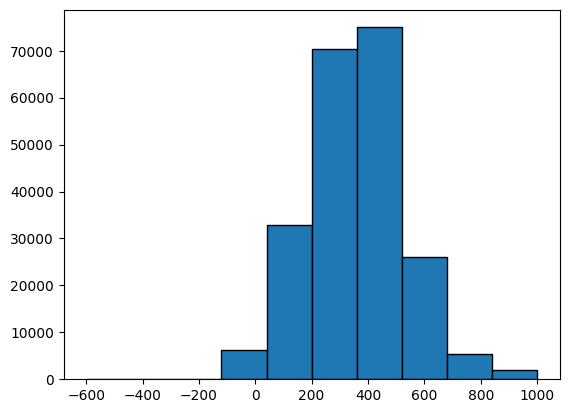

In [83]:
# UF output
import matplotlib.pyplot as plt
plt.hist(uf_events['valuenum'].clip(upper=1000), bins=10, edgecolor='black')
plt.show()

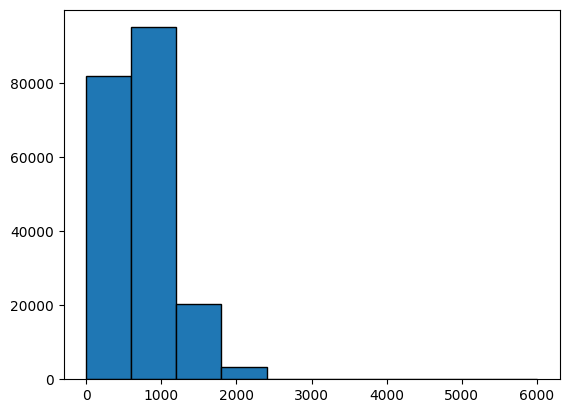

In [75]:
# DR input
plt.hist(dr_events['valuenum'].clip(upper=6000), bins=10, edgecolor='black')
plt.show()

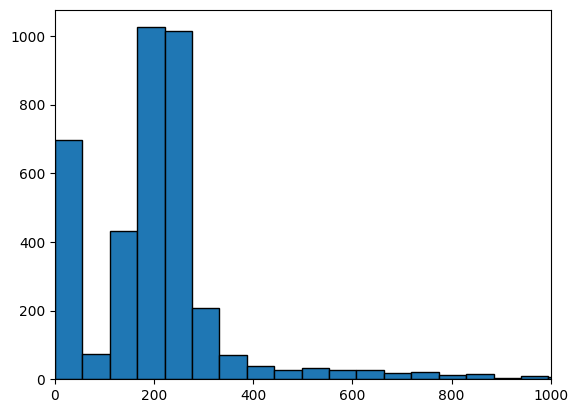

In [116]:
plt.hist(hd_events['value'], bins = 400, edgecolor='black')
plt.xlim(0,1000)
plt.show()